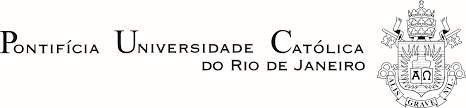

# Trabalho final - Data Mining

**Trabalho de conclusão da disciplina** | Manuel Calçada de Sousa - 202100175

---

## Índice

0. Introdução
1. Importação dos pacotes necessários
1. Obtenção dos dados
1. Análise exploratória
1. Pré-processamento I
1. Pré-processamento II
1. Machine learning
1. Conclusões

## 0. Introdução

**Objetivo principal**: 

Construir um modelo de machine learning que busque prever se um cavalo pode sobreviver ou não com base em condições médicas anteriores.


Dataset utilizado: https://www.kaggle.com/uciml/horse-colic

## 1. Importação dos pacotes necessários

Esta etapa compreende a importação dos pacotes necessários para as análises e modelagens, configurações e a definição de funções do usuário. 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import smote_variants as sv
import datetime
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, precision_score,f1_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_val_predict, ShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

### 1.1 Configurações

In [ ]:
pd.options.display.max_columns = None  # remove o limite da qtd de col exibidas
np.random.seed(10)  # define a semente aleatória
seed = 10  # define a semente aleatória

### 1.2 Funções

In [ ]:
# cria um gráfico com as matrizes de confusão de treino e de teste
def cf_plot(clf, X_train, X_test, y_train, y_test, method):
    acc_train = clf.score(X_train, y_train)
    acc_test = clf.score(X_test, y_test)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    cf_matrix_train = confusion_matrix(y_train, y_pred_train, normalize='true')
    cf_matrix_test = confusion_matrix(y_test, y_pred_test, normalize='true')
    disp_cf_matrix_train = ConfusionMatrixDisplay(
        cf_matrix_train, display_labels=['0', '1', '2', '3', '4'])
    disp_cf_matrix_test = ConfusionMatrixDisplay(
        cf_matrix_test, display_labels=['0', '1', '2', '3', '4'])
    f, axes = plt.subplots(1, 2, figsize=(15, 10), sharey='row')
    disp_cf_matrix_train.plot(ax=axes[0], cmap='Blues')
    disp_cf_matrix_train.ax_.set_xlabel(
        'Predicted label\naccuracy={:0.4f}'.format(acc_train)
                                        )
    disp_cf_matrix_test.plot(ax=axes[1], cmap='Blues')
    disp_cf_matrix_test.ax_.set_xlabel(
        'Predicted label\naccuracy={:0.4f}'.format(acc_test)
                                        )
    title_train = method+' (Train)'
    title_test = method+' (Test)'
    disp_cf_matrix_train.ax_.set_title(title_train)
    disp_cf_matrix_test.ax_.set_title(title_test)
    disp_cf_matrix_train.im_.colorbar.remove()
    disp_cf_matrix_test.im_.colorbar.remove()
    plt.show()

In [ ]:
# função para estilizar dataframe
def color_red(val):
    color = 'red' if np.abs(val) <= 0.105 else 'black'
    return 'color: %s' % color

In [ ]:
# classe para auxiliar a criação dos modelos
class ModeloAuxiliar(object):
    def __init__(self, clf, seed=seed, params=None):
        if params:
            params['random_state'] = seed
            self.clf = clf(**params)
        else:
            self.clf = clf()
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_
    
    def score(self,x,y):
        return self.clf.score(x,y)

## 2. Obtenção dos dados

O objetivo desta etapa é obter os dados através da base de dados fornecida (que foi disponibilizada no github) e verificar, em primeiro momento, os atributos disponíveis. 

In [ ]:
# importa a base de treino e teste
df_train = pd.read_csv('https://raw.githubusercontent.com/manuelcalcada/puc-datamining/main/horse.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/manuelcalcada/puc-datamining/main/horseTest.csv')

In [ ]:
# primeiras linhas da base de treino
df_train.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,NaN,NaN,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,NaN,NaN,NaN,absent,other,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,NaN,NaN,NaN,normal,normal,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,none,less_1_liter,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


In [ ]:
# exibe tamanho das bases de treino e teste
print('Número de linhas e de colunas da tabela de treino:', df_train.shape)
print('Número de linhas e de colunas da tabela de teste:', df_test.shape)

Número de linhas e de colunas da tabela de treino: (299, 28)
Número de linhas e de colunas da tabela de teste: (89, 28)


O dataset possui 28 variáveis (features) sendo:
 - 1 dependente (outcome)
 - 27 independentes

 Com 299 (77%) registros para treino e 89 (23%) registros para teste

## 3. Análise exploratória

O objetivo desta etapa é conhecer os dados, destrinchando seus atributos e distribuições, assim como visualizando relações entre eles a fim de gerar insights e para auxiliar nas escolhas a serem feitas para higienização dos mesmos e para a etapa de modelagem estatística. 

De forma geral, serão estudadas as estatísticas descritivas dos dados, assim como suas distribuições através de analises uni e bi variadas. Também serão identificados os outliers pelo método de amplitude interquantílica (IQR). 

### 3.1 Tipo dos dados

In [ ]:
# exibe as colunas, tipos e quantidades de dados da base de treino
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                299 non-null    object 
 1   age                    299 non-null    object 
 2   hospital_number        299 non-null    int64  
 3   rectal_temp            239 non-null    float64
 4   pulse                  275 non-null    float64
 5   respiratory_rate       241 non-null    float64
 6   temp_of_extremities    243 non-null    object 
 7   peripheral_pulse       230 non-null    object 
 8   mucous_membrane        252 non-null    object 
 9   capillary_refill_time  267 non-null    object 
 10  pain                   244 non-null    object 
 11  peristalsis            255 non-null    object 
 12  abdominal_distention   243 non-null    object 
 13  nasogastric_tube       195 non-null    object 
 14  nasogastric_reflux     193 non-null    object 
 15  nasoga

In [ ]:
# exibe a quantidade de valores únicos de cada campo (desconsiderando dados ausentes)
print('Valores únicos de cada campo: \n')
df_train.nunique()

Valores únicos de cada campo: 



surgery                    2
age                        2
hospital_number          283
rectal_temp               40
pulse                     52
respiratory_rate          40
temp_of_extremities        4
peripheral_pulse           4
mucous_membrane            6
capillary_refill_time      3
pain                       5
peristalsis                4
abdominal_distention       4
nasogastric_tube           3
nasogastric_reflux         3
nasogastric_reflux_ph     20
rectal_exam_feces          4
abdomen                    5
packed_cell_volume        50
total_protein             80
abdomo_appearance          3
abdomo_protein            37
outcome                    3
surgical_lesion            2
lesion_1                  61
lesion_2                   6
lesion_3                   2
cp_data                    2
dtype: int64

Não existem colunas com valor único em nossa tabela de treino, porém os atributos referentes à lesão sofrida pelo animal (lesion_1, lesion_2 e lesion_3) possuem muitos valores únicos para atributos do tipo categóricos em comparação com a quantidade de registros de treno, sendo assim, a princípio, eles não serão considerados para a construção do modelo, somente se as métricas de resultado não forem satisfatórias.

O atributo **hospital_number** diz respeito ao identificador recebido por cada animal no hospital veterinário, e por isso não será utilizado como variável preditora no modelo estatístico. É interessante notar que, de 299 registros, 283 são de pacientes únicos, ou seja, nesta base de dados existem pacientes que visitaram o hospital mais de uma vez. 

In [ ]:
# exibe as colunas com dados ausentes e a quantidade relativa (%) de dados faltantes
df_null = df_train.isnull().mean(axis = 0)
df_null = df_null[df_null > 0] * 100
print("Colunas com valores ausentes (qtd relativa): \n\n{}\n".format(df_null.sort_values(axis=0, ascending=False)))

Colunas com valores ausentes (qtd relativa): 

nasogastric_reflux_ph    82.274247
abdomo_protein           66.220736
abdomo_appearance        55.183946
abdomen                  39.464883
nasogastric_reflux       35.451505
nasogastric_tube         34.782609
rectal_exam_feces        34.113712
peripheral_pulse         23.076923
rectal_temp              20.066890
respiratory_rate         19.397993
temp_of_extremities      18.729097
abdominal_distention     18.729097
pain                     18.394649
mucous_membrane          15.719064
peristalsis              14.715719
total_protein            11.036789
capillary_refill_time    10.702341
packed_cell_volume        9.698997
pulse                     8.026756
dtype: float64



Utilizando o dicionário de dados fornecido com o dataset, é possível verificar, em primeiro lugar, que a variável **cp_data** pode ser descartada pois não há dados patológicos para suportá-la. 

Conforme resultados anteriores, a variável **nasogastric_reflux_ph** possui mais de 80% de dados ausentes, sendo assim ela também será descartada para diminuir possíveis viéses no modelo estatístico.

As variáveis categóricas com dados ausentes não serão tratadas, pois futuramente elas passarão por processos de encoding, sendo assim os dados ausentes serão capturados em uma dessas flags (que será posteriormente descartada). Estas variáveis são:
1. abdomen
1. nasogastric_reflux
1. rectal_examination_feces
1. peripheral_pulse
1. pain
1. mucous_membrane 
1. peristalsis
1. capillary_refill_time 

Já para as variáveis ordinais, os dados ausentes serão substituídos pela moda. A saber, estas variáveis são:

1. abdomo_appearance        
1. nasogastric_tube         
1. abdominal_distention     

Por fim, os dados ausentes das seguintes variáveis serão tratados conforme suas distribuições, a serem conhecidas na fase de análise exploratória dos dados:

1. abdomo_protein
1. total_protein
1. rectal_temp
1. packed_cell_volume
1. pulse
1. respiratory_rate

Com isso, para as próximas análises, as variáveis serão divididas em dois grupos, sendo o primeiro correspondente ás numéricas e o segundo contendo as categóricas (incluindo ordinais e dicotômicas)

In [ ]:
# variáveis numéricas
vars_num = ['rectal_temp', 
            'pulse', 
            'respiratory_rate', 
            'nasogastric_reflux_ph', 
            'packed_cell_volume',
            'total_protein',
            'abdomo_protein']

In [ ]:
# variáveis categóricas
vars_cat = ['surgery',
            'age',  
            'temp_of_extremities', 
            'peripheral_pulse',
            'mucous_membrane', 
            'capillary_refill_time', 
            'pain',  
            'peristalsis',  
            'abdominal_distention', 
            'nasogastric_tube',  
            'nasogastric_reflux',
            'rectal_exam_feces',
            'abdomen',
            'abdomo_appearance',
            'outcome',
            'surgical_lesion']

### 3.2 Análises univariadas

#### 3.2.1 Estatísticas descritivas

##### 3.2.1.1 Variáveis numéricas

Através das análises posteriores, é possível verificar estatísticas descritivas de cada campo numérico (como média, desvio padrão e os quartis), além de visualizar suas distribuições através de histogramas e outliers por boxplot. 

In [ ]:
# exibe estatísticas descritivas das variáveis numéricas
print('Estatísticas descritivas das variáveis numéricas: \n')
df_train[vars_num].describe().T

Estatísticas descritivas das variáveis numéricas: 



,count,mean,std,min,25%,50%,75%,max
rectal_temp,239.0,38.168619,0.733744,35.4,37.8,38.2,38.50,40.8
pulse,275.0,72.000000,28.646219,30.0,48.0,64.0,88.00,184.0
respiratory_rate,241.0,30.460581,17.666102,8.0,18.0,25.0,36.00,96.0
nasogastric_reflux_ph,53.0,4.707547,1.982311,1.0,3.0,5.0,6.50,7.5
packed_cell_volume,270.0,46.307407,10.436743,23.0,38.0,45.0,52.00,75.0
total_protein,266.0,24.274436,27.364194,3.3,6.5,7.5,56.75,89.0
abdomo_protein,101.0,3.039604,1.967947,0.1,2.0,2.3,3.90,10.1


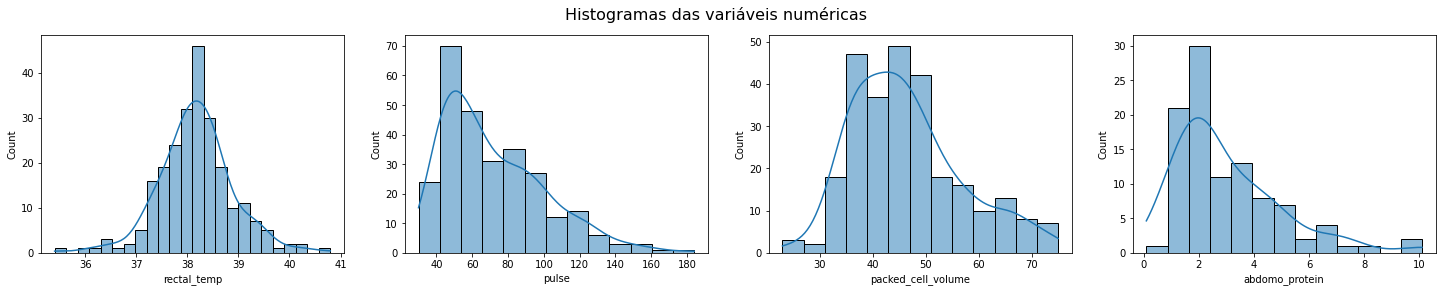

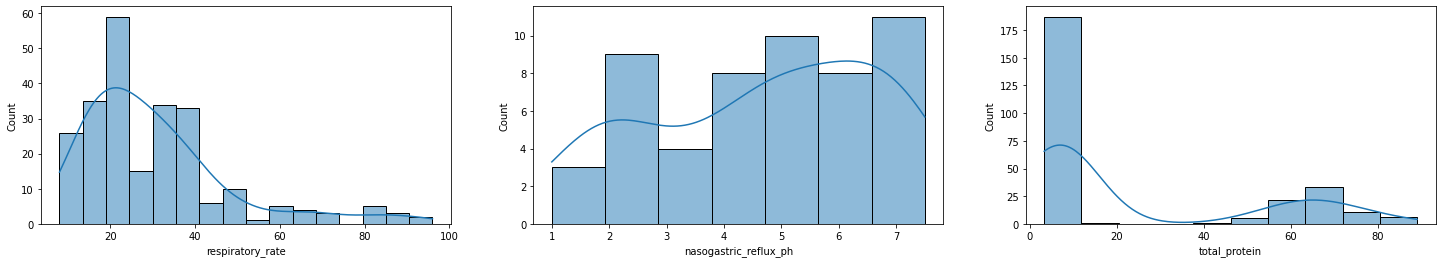

In [ ]:
# histogramas das variáveis numéricas
fig, axs = plt.subplots(1, 4, figsize=(25, 4))
sns.histplot(data=df_train, x="rectal_temp", kde=True, ax=axs[0])
sns.histplot(data=df_train, x="pulse", kde=True, ax=axs[1])
sns.histplot(data=df_train, x="packed_cell_volume", kde=True, ax=axs[2])
sns.histplot(data=df_train, x="abdomo_protein", kde=True, ax=axs[3])
fig.suptitle('Histogramas das variáveis numéricas', fontsize=16)
fig, axs = plt.subplots(1, 3, figsize=(25, 4))
sns.histplot(data=df_train, x="respiratory_rate", kde=True, ax=axs[0])
sns.histplot(data=df_train, x="nasogastric_reflux_ph", kde=True, ax=axs[1])
sns.histplot(data=df_train, x="total_protein", kde=True, ax=axs[2])
plt.show()

Através dos histogramas anteriores, é notório que a maioria dos atributos numéricos segue uma distribuição próxima a normal, com destaque apenas para nasogastric_reflux_ph que segue uma distribuição quase uniforme e total_protein, que possui dois picos. 

Sendo assim, por possuírem distribuições próximas à normal, optou-se por inserir o valor da mediana para os dados ausentes das variáveis respiratory_rate, abdomo_protein, rectal_temp, packed_cell_volume e pulse. Já para variável total_protein, pela presença de dois picos, optou-se pelo uso da média em detrimento da mediana.

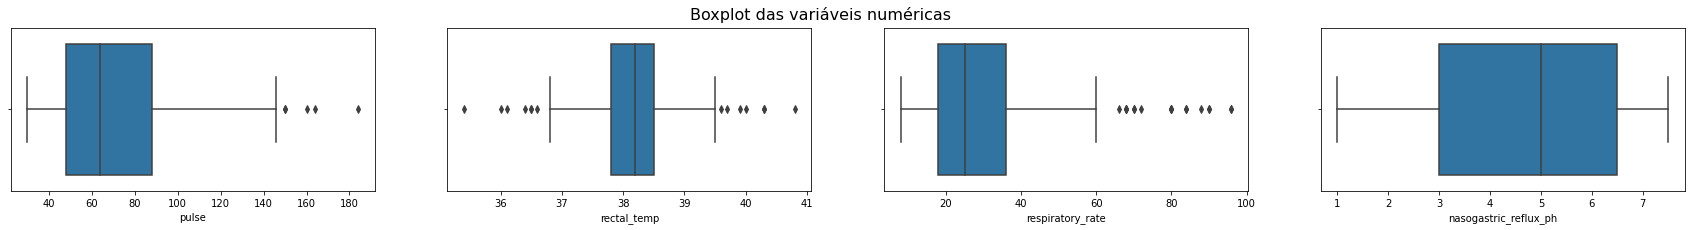

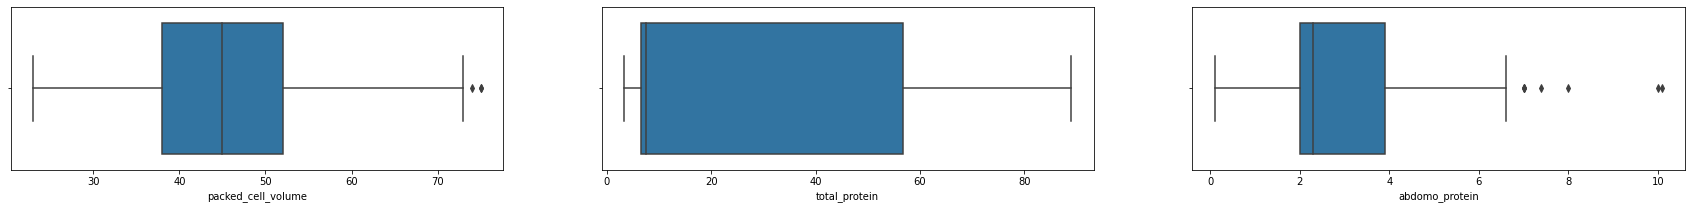

In [ ]:
# boxplot das variáveis numéricas
fig, axs = plt.subplots(1, 4, figsize=(30, 3))
fig.suptitle('Boxplot das variáveis numéricas', fontsize=16)
sns.boxplot(data=df_train, ax=axs[0], x='pulse')
sns.boxplot(data=df_train, ax=axs[1], x='rectal_temp')
sns.boxplot(data=df_train, ax=axs[2], x='respiratory_rate')
sns.boxplot(data=df_train, ax=axs[3], x='nasogastric_reflux_ph')
fig, axs = plt.subplots(1, 3, figsize=(30, 3))
sns.boxplot(data=df_train, ax=axs[0], x='packed_cell_volume')
sns.boxplot(data=df_train, ax=axs[1], x='total_protein')
sns.boxplot(data=df_train, ax=axs[2], x='abdomo_protein')
plt.show()

Através do método de amplitude interquantílica (IQR), foram identificados outliers superiores nas variáveis abdomo_protein, respiratory_rate, pulse e packed_cell_volume, assim como superiores e inferiores para rectal_temp.

Apesar de serem considerados outliers estatísticos, se faz necessário avaliar cada caso em conjunto com um especialista da área, a fim de definir outliers de negócio também. Para este trabalho, todos os outliers encontrados pelo IQR foram considerados como tal.

In [ ]:
IQR = df_train[vars_num].describe().T # obtém Q1 e Q3 das variáveis numéricas
IQR['IQR'] = IQR['75%'] - IQR['25%'] # amplitude interquantílica: IQR = Q3 - Q1
IQR['Limite inferior'] = IQR['25%'] - (1.5 * IQR['IQR']) # limite inferior: Q1 - 1.5*IQR
IQR['Limite inferior ajustado']  = IQR['Limite inferior'].apply(lambda x: 0 if x < 0 else x) # verifica se o limite inferior é negativo, se for, substitui por zero
IQR['Limite superior'] = IQR['75%'] + (1.5 * IQR['IQR']) # limite superior: Q3 + 1.5*IQR
IQR[['Limite inferior ajustado', 'Limite superior']] # exibe somente os limites inferior ajustado e superior

,Limite inferior ajustado,Limite superior
rectal_temp,36.75,39.550
pulse,0.00,148.000
respiratory_rate,0.00,63.000
nasogastric_reflux_ph,0.00,11.750
packed_cell_volume,17.00,73.000
total_protein,0.00,132.125
abdomo_protein,0.00,6.750


Através da análise anterior, chegou-se aos limites inferiores e superiores para a definição dos outliers pelo método IQR. O limite inferior precisou ser ajustado, pois estes atributos não poderiam assumir valores negativos. 


##### 3.2.1.2 Variáveis categóricas

Através das análises posteriores, é possível verificar a moda de cada uma dessas variáveis, assim como visualizar a distribuição de cada valor de forma univariada.

In [ ]:
# exibe estatísticas descritivas das variáveis categórias
print('Estatísticas descritivas das variáveis categóricas: \n')
df_train[vars_cat].describe().T

Estatísticas descritivas das variáveis categóricas: 



,count,unique,top,freq
surgery,299,2,yes,180
age,299,2,adult,275
temp_of_extremities,243,4,cool,108
peripheral_pulse,230,4,normal,114
mucous_membrane,252,6,normal_pink,79
capillary_refill_time,267,3,less_3_sec,187
pain,244,5,mild_pain,67
peristalsis,255,4,hypomotile,127
abdominal_distention,243,4,none,75
nasogastric_tube,195,3,slight,101


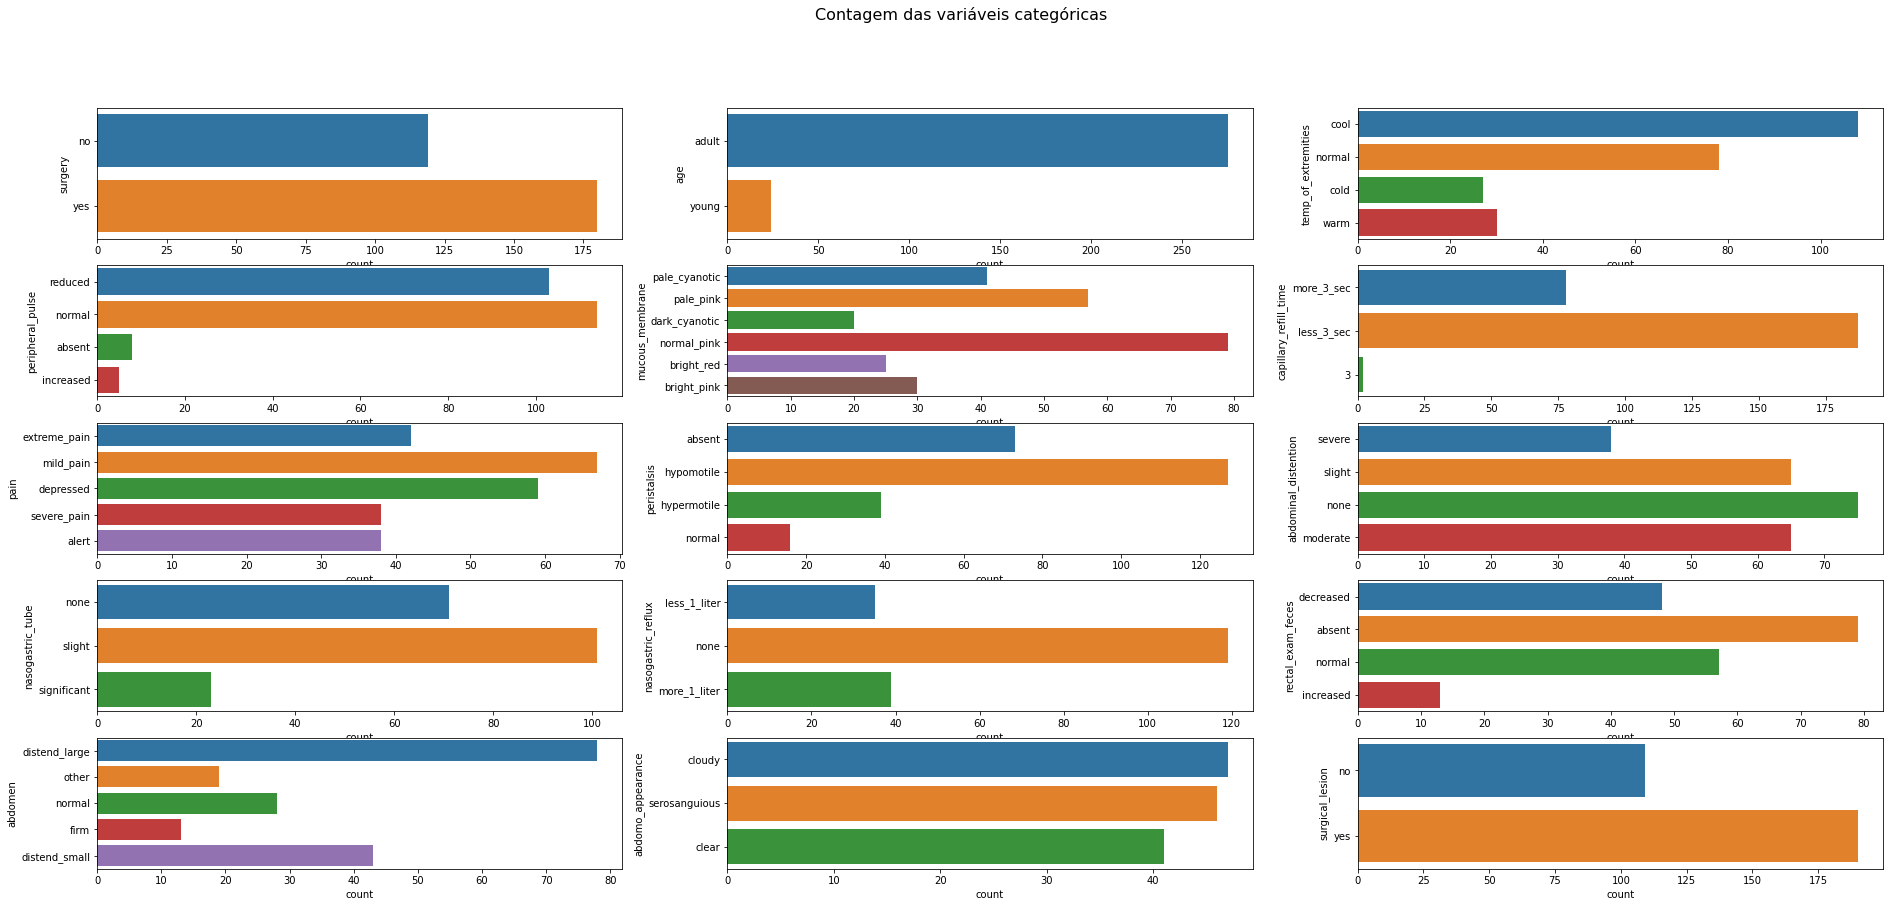

In [ ]:
# gráficos de contagem das variáveis categóricas
fig, axs = plt.subplots(5, 3, figsize=(32, 14))
sns.countplot(data=df_train, y="surgery", ax=axs[0, 0])
sns.countplot(data=df_train, y="age", ax=axs[0, 1])
sns.countplot(data=df_train, y="temp_of_extremities", ax=axs[0, 2])
sns.countplot(data=df_train, y="peripheral_pulse", ax=axs[1, 0])
sns.countplot(data=df_train, y="mucous_membrane", ax=axs[1, 1])
sns.countplot(data=df_train, y="capillary_refill_time", ax=axs[1, 2])
sns.countplot(data=df_train, y="pain", ax=axs[2, 0])
sns.countplot(data=df_train, y="peristalsis", ax=axs[2, 1])
sns.countplot(data=df_train, y="abdominal_distention", ax=axs[2, 2])
sns.countplot(data=df_train, y="nasogastric_tube", ax=axs[3, 0])
sns.countplot(data=df_train, y="nasogastric_reflux", ax=axs[3, 1])
sns.countplot(data=df_train, y="rectal_exam_feces", ax=axs[3, 2])
sns.countplot(data=df_train, y="abdomen", ax=axs[4, 0])
sns.countplot(data=df_train, y="abdomo_appearance", ax=axs[4, 1])
sns.countplot(data=df_train, y="surgical_lesion", ax=axs[4, 2])
fig.suptitle('Contagem das variáveis categóricas', fontsize=16)
plt.show()

Estas análises nos permitem conhecer os dados, fundamental para a etapa de modelagem estatística, e obter alguns insights. Por exemplo, é possível observar que, a maioria dos cavalos atendidos é adulto, com dor média, previamente operados e com lesões cirúrgicas. 

##### 3.2.1.3 Variável predita (dependente)

Passando agora para a variável a ser predita, isto é, o atributo que contém a informação se o cavalo sobreviveu, sofreu eutanásia ou morreu, pode-se também verificar uma contagem de suas classes, como uma variável categórica.

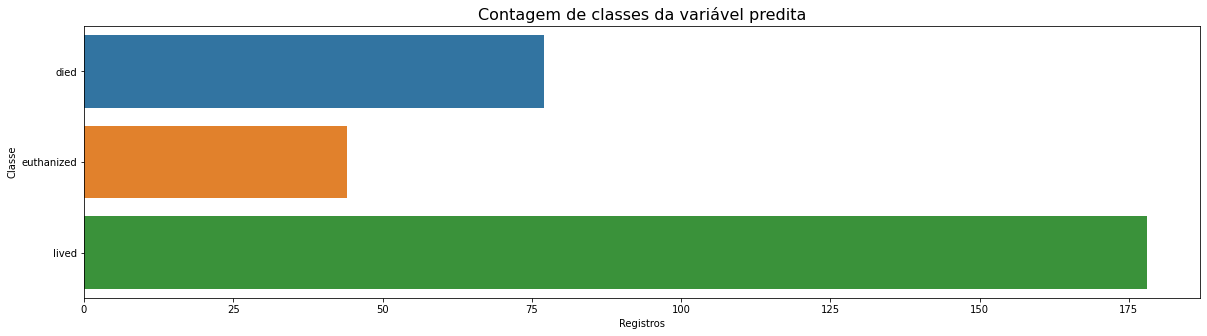

In [ ]:
# gráfico com contagem de classes da variável predita
plt.figure(figsize=(20,5))
sns.countplot(data=df_train, y="outcome")
plt.title('Contagem de classes da variável predita', fontsize=16)
plt.xlabel('Registros')
plt.ylabel('Classe')
plt.show()

É notório o desbalanceamento entre as três classes que formam a variável predita (dependente), a saber: 
1. died (indica que o cavalo morreu)
1. euthanized (indica que o cavalo sofreu eutanásia)
1. lived (indica que o cavalo sobreviveu)

A fim de mitigar viéses para as classes majoritárias, é necessário aplicar alguma técnica de balanceamento de dados. Uma forma de fazer isso sem gerar dados sintéticos é classificando cavalos que sofreram eutanásia como se pertencentes a classe 'died', pois o destino foi o mesmo. Sendo assim, temos uma distribuição mais balanceada e nosso problema passou de uma classificação multiclasse para uma classificação binária.

In [ ]:
# substitui registros euthanized por died no atributo outcome
df_train.outcome.replace({'euthanized': 'died'}, inplace=True)

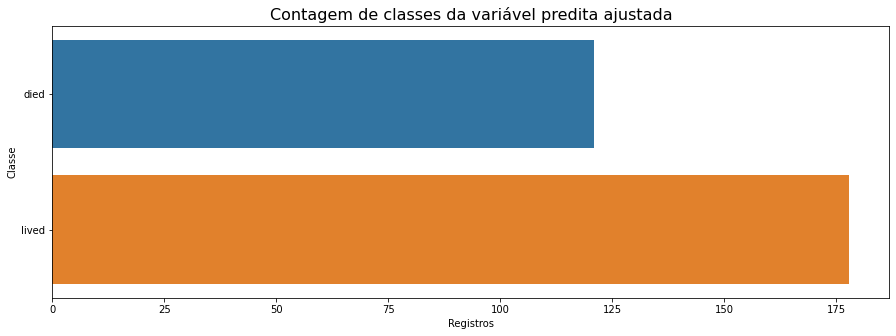

In [ ]:
# gráfico com contagem de classes da variável predita ajustada
plt.figure(figsize=(15,5))
sns.countplot(data=df_train, y="outcome")
plt.title('Contagem de classes da variável predita ajustada', fontsize=16)
plt.xlabel('Registros')
plt.ylabel('Classe')
plt.show()

In [ ]:
# exibe a distribuição relativa (%) de classes da variável outcome após o ajuste
print("Distribuição relativa das classes: \n")
df_train.outcome.value_counts()/df_train.shape[0] * 100

Distribuição relativa das classes: 



lived    59.531773
died     40.468227
Name: outcome, dtype: float64

Com isso, conseguimos mitigar o desbalanceamento, contendo 59% dos dados de cavalos que viveram e 40% com cavalos que morreram. Na etapa de modelagem estatística será avaliado se é necessário adotar outro balanceamento para o desenvolvimento do modelo.

##### 3.2.1.4 Variável de identificação

Por fim, analisa-se a variável de identificação do animal, a saber: hospital_id. Esta variável anonimizada não será utilizada no treinamento do modelo, por se tratar de um identificador, mas pode ser útil na análise exploratória a fim de estudar os casos de cavalos que foram atendidos mais de uma vez. 

In [ ]:
# exibe um dataframe somente com os registros que possuem hospital_number duplicado
pd.concat(g for _, g in df_train.groupby("hospital_number") if len(g) > 1)

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
110,yes,adult,527544,NaN,70.0,16.0,cool,absent,bright_red,more_3_sec,depressed,hypomotile,slight,slight,none,NaN,absent,distend_large,60.0,7.5,NaN,NaN,died,yes,2112,0,0,no
281,yes,adult,527544,NaN,70.0,16.0,cool,absent,bright_red,more_3_sec,depressed,hypomotile,slight,slight,none,NaN,absent,distend_large,60.0,7.5,NaN,NaN,died,yes,1400,0,0,no
159,yes,adult,527916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,severe_pain,NaN,NaN,none,none,NaN,NaN,distend_large,35.0,58.0,cloudy,1.0,lived,yes,4205,0,0,no
165,yes,adult,527916,38.3,40.0,18.0,normal,normal,normal_pink,less_3_sec,mild_pain,hypermotile,none,NaN,NaN,NaN,increased,normal,43.0,5.9,clear,NaN,lived,no,0,0,0,yes
178,no,adult,528151,38.5,100.0,NaN,cool,reduced,bright_red,more_3_sec,severe_pain,hypomotile,severe,slight,none,NaN,absent,distend_large,NaN,NaN,NaN,NaN,died,no,1111,0,0,yes
204,no,adult,528151,38.5,100.0,NaN,cool,reduced,bright_red,more_3_sec,severe_pain,hypomotile,severe,slight,none,NaN,absent,distend_large,NaN,NaN,NaN,NaN,died,no,4124,0,0,no
73,yes,adult,528469,38.1,52.0,24.0,normal,normal,bright_red,less_3_sec,severe_pain,hypomotile,none,slight,more_1_liter,7.0,normal,NaN,54.0,7.5,cloudy,2.6,died,yes,2112,0,0,yes
234,yes,adult,528469,38.1,52.0,24.0,normal,normal,bright_red,less_3_sec,severe_pain,hypomotile,none,slight,more_1_liter,7.0,normal,NaN,54.0,7.5,cloudy,2.6,died,yes,2206,0,0,yes
94,no,adult,528729,37.5,48.0,30.0,cold,normal,pale_pink,less_3_sec,NaN,normal,none,none,none,NaN,normal,normal,48.0,8.6,NaN,NaN,lived,no,0,0,0,no
233,no,adult,528729,37.5,48.0,30.0,cold,normal,pale_pink,less_3_sec,NaN,normal,none,none,none,NaN,normal,normal,48.0,8.6,NaN,NaN,lived,no,400,0,0,no


Apesar da hipótese inicial para possuir dados duplicados ter sido que esses animais foram atendidos duas vezes, através da tabela anterior é possível verificar que isto não é verdade, e sim as linhas estão duplicadas, com ligeira diferença entre algumas. Inclusive, cavalos que morreram estão duplamente registrados na tabela de treino.

Sendo assim, serão excluídas as duplicadas, a fim de permanecermos somente com um registro de cada animal.

In [ ]:
print('Tamanho do dataset antes da remoção de duplicatas:', df_train.shape)
df_train.drop_duplicates(subset='hospital_number', keep="last", inplace=True)
print('Tamanho do dataset após a remoção de duplicatas:', df_train.shape)

Tamanho do dataset antes da remoção de duplicatas: (299, 28)
Tamanho do dataset após a remoção de duplicatas: (283, 28)


### 3.3 Análises bivariadas

#### 3.3.1 Variáveis preditivas numéricas x variável predita

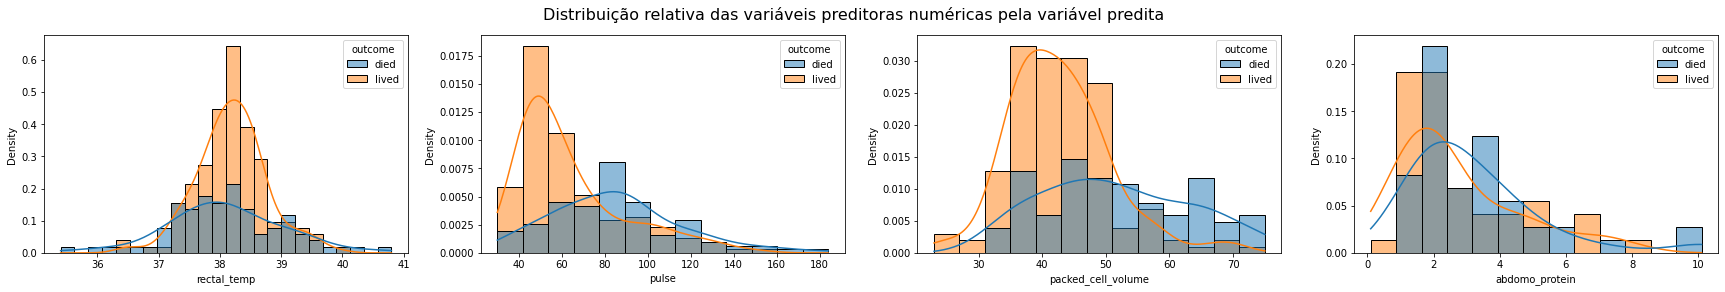

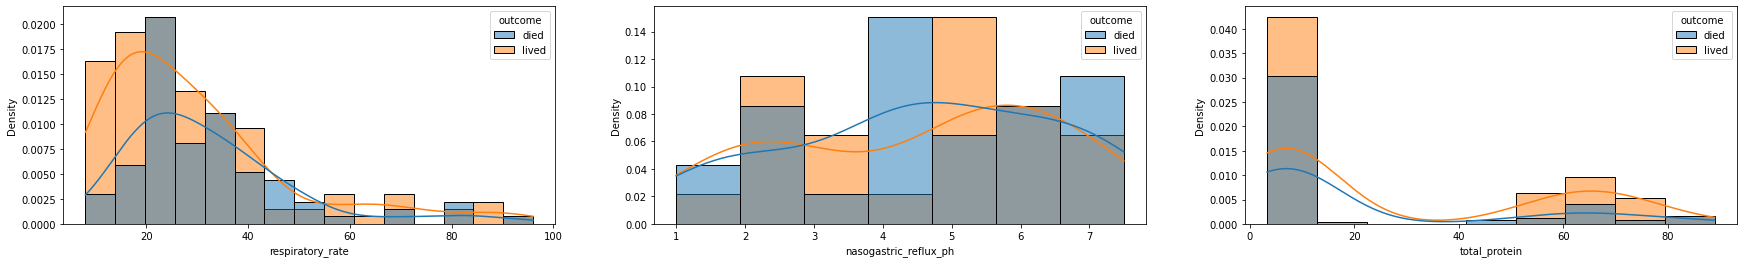

In [ ]:
# distribuição das variáveis numéricas pela variável predita
fig, axs = plt.subplots(1, 4, figsize=(30, 4))
sns.histplot(data=df_train, x="rectal_temp", kde=True, ax=axs[0], hue=df_train.outcome, stat="density")
sns.histplot(data=df_train, x="pulse", kde=True, ax=axs[1], hue=df_train.outcome, stat="density")
sns.histplot(data=df_train, x="packed_cell_volume", kde=True, ax=axs[2], hue=df_train.outcome, stat="density")
sns.histplot(data=df_train, x="abdomo_protein", kde=True, ax=axs[3], hue=df_train.outcome, stat="density")
fig.suptitle('Distribuição relativa das variáveis preditoras numéricas pela variável predita', fontsize=16)
fig, axs = plt.subplots(1, 3, figsize=(30, 4))
sns.histplot(data=df_train, x="respiratory_rate", kde=True, ax=axs[0], hue=df_train.outcome, stat="density")
sns.histplot(data=df_train, x="nasogastric_reflux_ph", kde=True, ax=axs[1], hue=df_train.outcome, stat="density")
sns.histplot(data=df_train, x="total_protein", kde=True, ax=axs[2], hue=df_train.outcome, stat="density")
plt.show()

Os gráficos anteriores nos permitem observar o comportamento dos dois grupos em relação às variáveis numéricas. É possível observar que, relativamente, a temperatura retal dos cavalos que morreram está melhor distribuída entre os limites inferiores e superiores, enquanto que, os cavalos que viveram, geralmente possuíam temperaturas medianas (por volta de 38 C). 

Já para a pulsação, é notório que os cavalos que viveram possuiam valores de pulso mais baixos do que cavalos que morreram. No entanto, há a presença de cavalos que viveram mesmo com pulsação elevada. 

Para packed_cell_volume, é possível verificar que cavalos que evoluíram a óbito geralmente possuem valores maiores para esta variável em comparação com cavalos que viveram, ao contrário do que acontece na taxa de respiração, onde cavalos que viveram geralmente possuem taxas menores do que os que morreram.

#### 3.3.2 Variáveis preditivas categóricas x variável predita

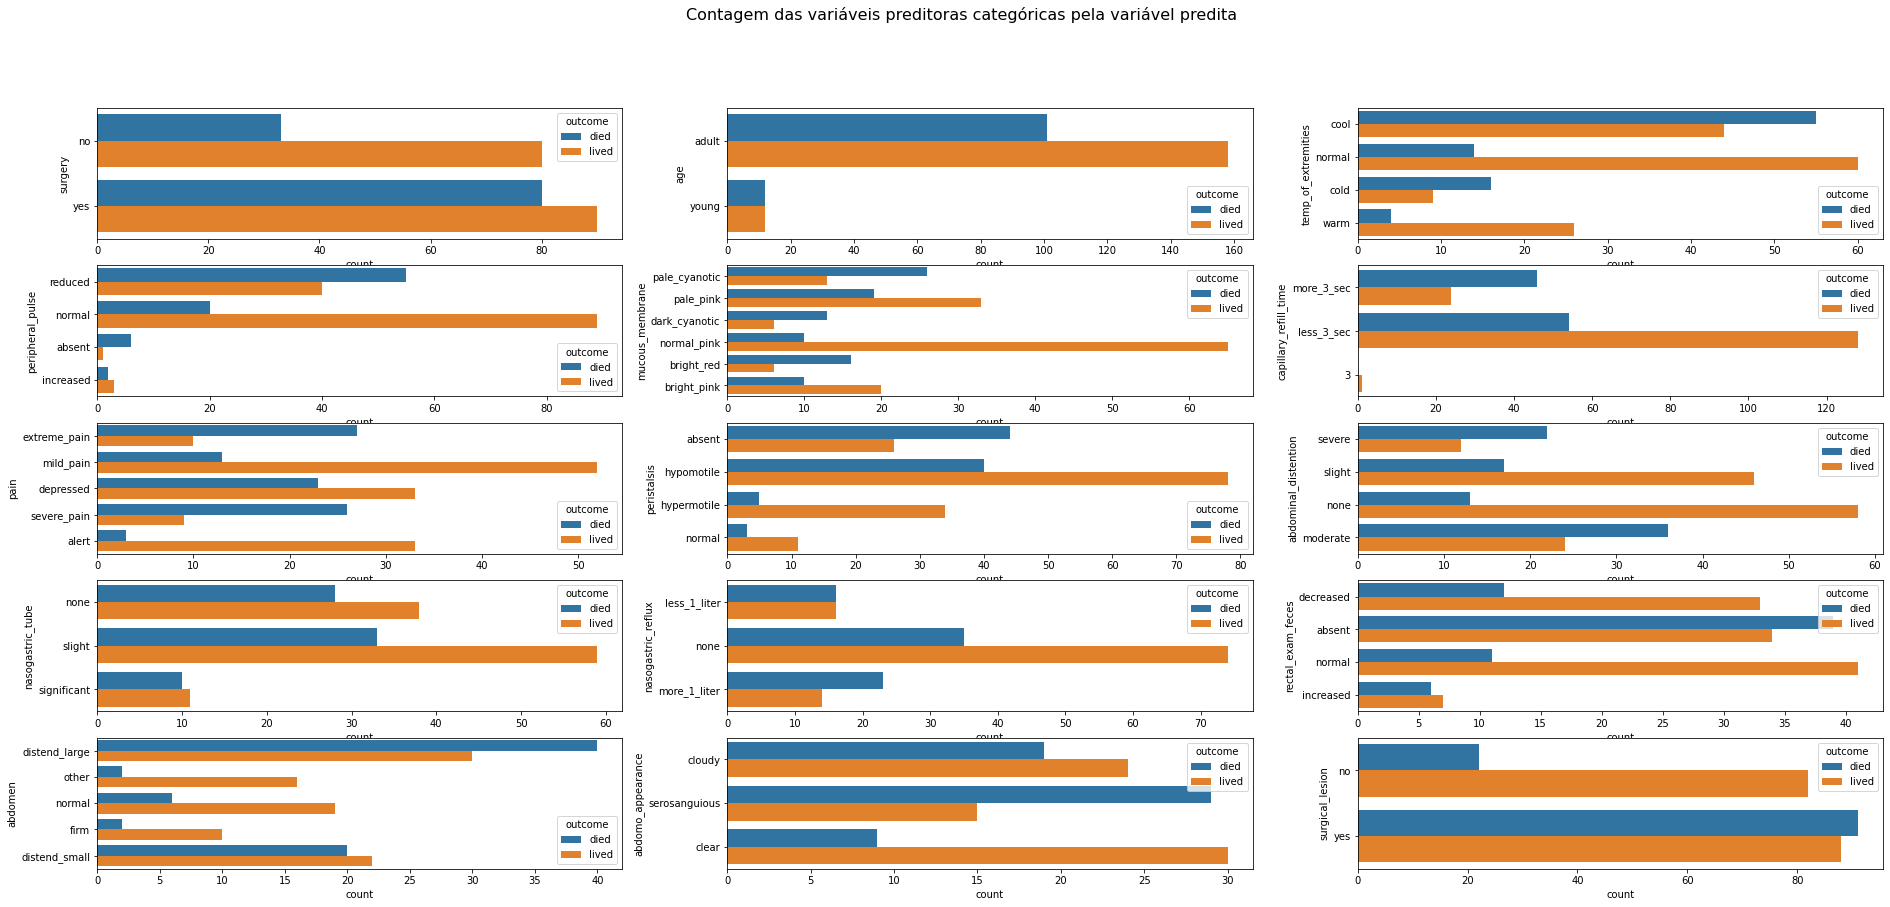

In [ ]:
# gráficos de contagem das variáveis categóricas
fig, axs = plt.subplots(5, 3, figsize=(32, 14))
sns.countplot(data=df_train, y="surgery", ax=axs[0, 0], hue=df_train.outcome)
sns.countplot(data=df_train, y="age", ax=axs[0, 1], hue=df_train.outcome)
sns.countplot(data=df_train, y="temp_of_extremities", ax=axs[0, 2], hue=df_train.outcome)
sns.countplot(data=df_train, y="peripheral_pulse", ax=axs[1, 0], hue=df_train.outcome)
sns.countplot(data=df_train, y="mucous_membrane", ax=axs[1, 1], hue=df_train.outcome)
sns.countplot(data=df_train, y="capillary_refill_time", ax=axs[1, 2], hue=df_train.outcome)
sns.countplot(data=df_train, y="pain", ax=axs[2, 0], hue=df_train.outcome)
sns.countplot(data=df_train, y="peristalsis", ax=axs[2, 1], hue=df_train.outcome)
sns.countplot(data=df_train, y="abdominal_distention", ax=axs[2, 2], hue=df_train.outcome)
sns.countplot(data=df_train, y="nasogastric_tube", ax=axs[3, 0], hue=df_train.outcome)
sns.countplot(data=df_train, y="nasogastric_reflux", ax=axs[3, 1], hue=df_train.outcome)
sns.countplot(data=df_train, y="rectal_exam_feces", ax=axs[3, 2], hue=df_train.outcome)
sns.countplot(data=df_train, y="abdomen", ax=axs[4, 0], hue=df_train.outcome)
sns.countplot(data=df_train, y="abdomo_appearance", ax=axs[4, 1], hue=df_train.outcome)
sns.countplot(data=df_train, y="surgical_lesion", ax=axs[4, 2], hue=df_train.outcome)
fig.suptitle('Contagem das variáveis preditoras categóricas pela variável predita', fontsize=16)
plt.show()

Analisando agora as diferenças entre os dois grupos (cavalos que sobreviveram e que morreram) nas variáveis categórias, é possível verificar que:

1. Mais cavalos morrem quando passam por procedimentos cirúrgicos
1. Mais cavalos morrem quando a temperatura de suas extremidades está baixa
1. Mais cavalos morrem quando peripheral_pulse está reduzida ou inexistente
1. Dores extremas e severas estão mais correlacionadas com a evolução à óbito pelos cavalos
1. A presença de lesões cirúrgicas está relacionada à uma alta diferença entre cavalos que morreram e que sobreviveram

Essas análises podem ser feitas para todos as variáveis categóricas, pois todas apresentaram diferença significativa entre os grupos analisados. Para não ser exaustivo neste trabalho, apenas elenquei 5 insights retirados desta análise. 

#### 3.3.3 Dados ausentes x variável predita

Faz-se necessário verificar possíveis padrões nos dados ausentes em relação a variável predita, a fim de verificar o tratamento adequado para a substituição dos mesmos, mitigando a adição de viéses.

In [ ]:
# exibe a quantidade relativa de dados ausentes em função da variável predita
print('Quantidade relativa de dados ausentes pela variável predita: \n')
df_lived = df_train[df_train['outcome'] == 'lived'] # cria um dataframe somente com casos onde os cavalos sobreviveram
df_died = df_train[df_train['outcome'] == 'died'] # cria um dataframe somente com casos onde os cavalos morreram
df_lived_null = df_lived.isnull().mean(axis = 0) # obtem a quantidade de dados ausentes no dataframe contendo somente casos onde os cavalos sobrevieram
df_lived_null = df_lived_null[df_lived_null > 0] * 100
df_died_null = df_died.isnull().mean(axis = 0) # obtem a quantidade de dados ausentes no dataframe contendo somente casos onde os cavalos morreram
df_died_null = df_died_null[df_died_null > 0] * 100
df_died_null = pd.DataFrame(df_died_null, columns=['Missing_'])
df_lived_null = pd.DataFrame(df_lived_null, columns=['Missing_'])
df_null_joined = df_died_null.join(df_lived_null,lsuffix='lived', rsuffix='died', how='left') # une os dois dataframes
df_null_joined['DIF'] = np.abs(df_null_joined['Missing_lived'] - df_null_joined['Missing_died']) # módulo da diferença relativa entre os dados ausentes de cada classe
df_null_joined.sort_values(by='DIF', ascending = False) # ordena o dataframe pela coluna DIF
df_null_joined.style.highlight_max(color = 'orange', axis = 1) # exibe o dataframe e marca os maiores valores por linha

Quantidade relativa de dados ausentes pela variável predita: 



,Missing_lived,Missing_died,DIF
rectal_temp,27.433628,14.117647,13.315981
pulse,8.849558,6.470588,2.378969
respiratory_rate,21.238938,17.058824,4.180115
temp_of_extremities,21.238938,18.235294,3.003644
peripheral_pulse,26.548673,21.764706,4.783967
mucous_membrane,16.814159,15.882353,0.931806
capillary_refill_time,11.504425,10.000000,1.504425
pain,18.584071,19.411765,0.827694
peristalsis,18.584071,12.352941,6.231130
abdominal_distention,22.123894,17.647059,4.476835


A análise anterior exibe a quantidade de dados ausentes para os cavaos que sobreviveram e para os que morreram, com destaque em laranja para a classe com maior quantidade de dados ausentes em cada atributo. 

De forma geral, a diferença entre os dados ausentes de cada classe é pequena (< 10%), com excessão para alguns atributos como **abdomo_protein** e **rectal_temp**, que possuem menos dados em cavalos que morreram e sobreviveram respectivamente. 

Sendo assim, não há padrão visível para estes dados ausentes, o que poderia gerar viéses na substituição dos mesmos, então podemos prosseguir a esta modificação. 

## 4. Pré-processamento I

O objetivo desta etapa é iniciar o pré-processamento dos dados, começando pela inputação de valores ausentes (missing values), realizando encoding de variáveis não-numéricas (para que todos os modelos estatísticos) possam ser testados de forma igualitária, incluindo os que não necessitariam disso, como os baseados em árvore de decisão), passando pela exlusão de atributos e finalizando com o tratamento de outliers.

Por fim, serão estudados as correlações entre os atributos na base de teste, assim como serão aplicadas as mesmas transformações na base de treino.

In [ ]:
# criando backup
df_train_bckp = df_train.copy()

### 4.1 Tratamento de valores faltantes

A substituição de valores ausentes seguirá as escolhas exibidas anteriormente. 

In [ ]:
# efetua a substituição de dados ausentes conforme transformações anteriormente definidas
df_train['abdomo_protein'] = df_train['abdomo_protein'].fillna(2.3) # substituição pela mediana
df_train['total_protein'] = df_train['total_protein'].fillna(24.274436) # substituição pela média
df_train['rectal_temp'] = df_train['rectal_temp'].fillna(38.2) # substituição pela mediana
df_train['packed_cell_volume'] = df_train['packed_cell_volume'].fillna(45.0) # substituição pela mediana
df_train['pulse'] = df_train['pulse'].fillna(64.0) # substituição pela mediana
df_train['respiratory_rate'] = df_train['respiratory_rate'].fillna(25.0) # substituição pela mediana

### 4.2 Encoding

Para alguns modelos, como regressão logística e redes neurais, precisamos transformar todos os atributos em numéricos. Para alimentarmos todos os modelos de forma igualitária, iremos realizar estas transformações na base inteira, levando em conta as informações presentes no dicionário de dados.

#### 4.2.1 Variáveis dicotômicas

In [ ]:
# de-para de valores categóricos para numéricos
df_train['surgery'] = df_train['surgery'].map({'yes': 1, 'no': 0})
df_train['surgical_lesion'] = df_train['surgical_lesion'].map({'yes': 1, 'no': 0})
df_train['adult'] = df_train['age'].map({'adult': 1, 'young': 0})

#### 4.2.2 Variáveis ordinais

In [ ]:
# preenche valores ausentes com a moda
df_train['abdominal_distention'] = df_train['abdominal_distention'].fillna('none') # substituição pela moda
df_train['nasogastric_tube'] = df_train['nasogastric_tube'].fillna('slight') # substituição pela moda
df_train['abdomo_appearance'] = df_train['abdomo_appearance'].fillna('cloudy') # substituição pela moda

In [ ]:
# de-para de valores ordinais para numéricos (existe uma ordem entre as categorias)
df_train['abdominal_distention'] = df_train['abdominal_distention'].map({'none': 1, 'slight': 2, 'moderate': 3, 'severe': 4})
df_train['nasogastric_tube'] = df_train['nasogastric_tube'].map({'none': 1, 'slight': 2, 'significant': 3})
df_train['abdomo_appearance'] = df_train['abdomo_appearance'].map({'clear': 1, 'cloudy': 2, 'serosanguious': 3})

#### 4.2.3 Variáveis categóricas

In [ ]:
# define as variáveis categóricas para encoding
vars_cat_encoding = ['temp_of_extremities',
            'peripheral_pulse',
            'mucous_membrane',
            'capillary_refill_time',
            'pain',
            'peristalsis',
            'nasogastric_reflux',
            'rectal_exam_feces',
            'abdomen']

In [ ]:
# aplica o one hot encoding nas variáveis categóricas, criando variáveis dicotômicas para cada categoria
df_train = pd.get_dummies(df_train, columns=vars_cat_encoding)

#### 4.2.4 Variável predita

In [ ]:
# de-para para valores dicotômicos na variável resposta
df_train['outcome'] = df_train['outcome'].map({'died': 1, 'lived': 0})

### 4.3 Exclusão de colunas

In [ ]:
# exclui as colunas que não serão utilizadas na modelagem estatística
del df_train['age']
del df_train['hospital_number']
del df_train['nasogastric_reflux_ph']
del df_train['cp_data']
del df_train['lesion_1']
del df_train['lesion_2']
del df_train['lesion_3']

### 4.4 Tratamento de outliers

O tratamento de outliers será feito utilizando o método de amplitude interquantílica (IQR). Isto é, os valores que estiverem abaixo do limite inferior receberão o limite inferior como o novo valor, e os valores acima do limite superior serão substituídos pelo limite superior. 

Estes valores foram obtidos anteriormente, na etapa de análise exploratória de dados.

In [ ]:
df_train.loc[df_train.rectal_temp < 36.75, 'rectal_temp'] = 36.75 # trata outliers inferiores de rectal_temp
df_train.loc[df_train.rectal_temp > 39.55, 'rectal_temp'] = 39.55 # trata outliers superiores de rectal_temp
df_train.loc[df_train.pulse < 0.0, 'pulse'] = 0.0 # trata outliers inferiores de pulse
df_train.loc[df_train.pulse > 148.0, 'pulse'] = 148.0 # trata outliers superiores de pulse
df_train.loc[df_train.respiratory_rate < 0.0, 'respiratory_rate'] = 0.0 # trata outliers inferiores de respiratory_rate
df_train.loc[df_train.respiratory_rate > 63.0, 'respiratory_rate'] = 63.0 # trata outliers superiores de respiratory_rate
df_train.loc[df_train.packed_cell_volume < 17.0, 'packed_cell_volume'] = 17.0 # trata outliers inferiores de packed_cell_volume
df_train.loc[df_train.packed_cell_volume > 73.0, 'packed_cell_volume'] = 73.0 # trata outliers superiores de packed_cell_volume
df_train.loc[df_train.total_protein < 0.0, 'total_protein'] = 0.0 # trata outliers inferiores de total_protein
df_train.loc[df_train.total_protein > 132.12, 'total_protein'] = 132.12 # trata outliers superiores de total_protein
df_train.loc[df_train.abdomo_protein < 0.0, 'abdomo_protein'] = 0.0 # trata outliers inferiores de abdomo_protein
df_train.loc[df_train.abdomo_protein > 6.75, 'abdomo_protein'] = 6.75 # trata outliers superiores de abdomo_protein

### 4.5 Resultados

Por fim, serão verificados os dados resultades destes processamentos.
Primeiro verifica-se a presença de alguma coluna com dados ausentes, depois estuda-se a multicolinariedade e a correlação entre as variáveis. 

In [ ]:
#exibe as colunas com dados ausentes e a quantidade relativa (%) de dados faltantes
df_null = df_train.isnull().mean(axis = 0)
df_null = df_null[df_null > 0] * 100
print("Colunas com valores ausentes (qtd relativa): \n\n{}\n".format(df_null.sort_values(axis=0, ascending=False)))

Colunas com valores ausentes (qtd relativa): 

Series([], dtype: float64)



In [ ]:
df_train.head()

,surgery,rectal_temp,pulse,respiratory_rate,abdominal_distention,nasogastric_tube,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,adult,temp_of_extremities_cold,temp_of_extremities_cool,temp_of_extremities_normal,temp_of_extremities_warm,peripheral_pulse_absent,peripheral_pulse_increased,peripheral_pulse_normal,peripheral_pulse_reduced,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink,capillary_refill_time_3,capillary_refill_time_less_3_sec,capillary_refill_time_more_3_sec,pain_alert,pain_depressed,pain_extreme_pain,pain_mild_pain,pain_severe_pain,peristalsis_absent,peristalsis_hypermotile,peristalsis_hypomotile,peristalsis_normal,nasogastric_reflux_less_1_liter,nasogastric_reflux_more_1_liter,nasogastric_reflux_none,rectal_exam_feces_absent,rectal_exam_feces_decreased,rectal_exam_feces_increased,rectal_exam_feces_normal,abdomen_distend_large,abdomen_distend_small,abdomen_firm,abdomen_normal,abdomen_other
0,0,38.5,66.0,28.0,4,2,45.0,8.4,2,2.3,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,1,39.2,88.0,20.0,2,2,50.0,85.0,2,2.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,0,38.3,40.0,24.0,1,2,33.0,6.7,2,2.3,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,1,39.1,148.0,63.0,4,1,48.0,7.2,3,5.3,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,0,37.3,104.0,35.0,1,2,73.0,7.4,2,2.3,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 4.5.1 Verificação de multicolinariedade

A fim de reduzir a complexidade do modelo, é necessário verificar se existe multicolinariedade entre as variáveis. Pelo método de pearson, serão identificadas as correlações entre as variáveis numéricas, conforme imagem abaixo. Para conhecermos as correlações originais, utilizaremos os dados antes do pré-processamento.

In [ ]:
# cria uma lista com as variáveis numéricas para correlação
vars_num_corr = ['rectal_temp',
 'pulse',
 'respiratory_rate',
 'packed_cell_volume',
 'total_protein',
 'abdomo_protein']

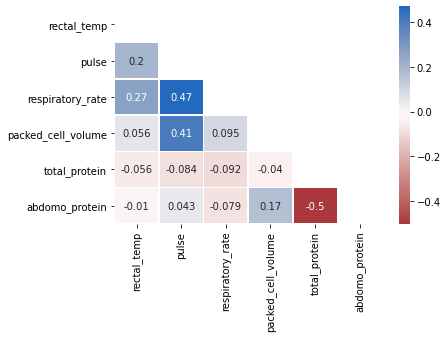

In [ ]:
# exibe a matriz de correlação das variáveis numéricas
corrMatrix = df_train_bckp[vars_num_corr].corr()
mask = np.triu(np.ones_like(df_train_bckp[vars_num_corr].corr(), dtype=bool))
sns.heatmap(corrMatrix, annot=True, cmap="vlag_r", linewidths=0.5, linecolor='white', mask=mask)
plt.show()

A maior correlação (absoluta) é de 0.47 (entre pulse e respiratory_rate), o que não aparenta representar multicolinariedade, e sim uma relação natural entre a pulsação e a taxa de respiração. 

Outra correlação que vale a pena destacar é entre packed_cell_volume e pulse, que também são diretamente proporcionais, isto é, quanto maior a pulsação, maior a quantidade de glóbulos vermelhos no sangue do animal.

Ao contrário,total_protein e abdomo_protein apresentam uma correlação negativa, significando que quando maior a quantidade total de proteínas, menor a quantidade de proteínas abdomcentesis. De acordo com o dicionário de dados, isto está ligado principalmente à desidratação sofrida pelo animal.   

#### 4.5.2 Verificação de correlação com variável predita

Para esta verificação, será utilizado a correlação de Kendall para verificarmos quantitativamente como os atributos se relacionam com a variável predita (outcome). Esta é uma etapa importante para a seleção de variáveis, visto que variáveis com uma baixa correlação podem não ser tão significativas para o modelo estatístico.

In [ ]:
# exibe a correlação entre as variáveis preditoras com a variável predita
outcome_corr = pd.DataFrame(df_train.corr(method='kendall')['outcome'])
outcome_corr.columns = ['Correlação com a variável predita']
outcome_corr = outcome_corr.sort_values(by='Correlação com a variável predita', ascending=False, key=abs)[1:]
outcome_corr.style.bar(subset=['Correlação com a variável predita'], align='mid', color=['#d65f5f', '#5fba7d']).applymap(color_red).set_precision(2)

,Correlação com a variável predita
peripheral_pulse_normal,-0.35
mucous_membrane_normal_pink,-0.33
pulse,0.31
packed_cell_volume,0.30
capillary_refill_time_more_3_sec,0.30
surgical_lesion,0.29
capillary_refill_time_less_3_sec,-0.28
peristalsis_absent,0.27
pain_severe_pain,0.26
pain_extreme_pain,0.26


A análise anterior traz a correlação entre os atributos e a variável resposta (outcome), ordenados decrescentemente em relação a magnitude desta relação. Adicionalmente, existem barras verdes e vermelhas que demonstram visualmente o sentido e o peso desta correlação, sendo verde uma correlação positiva e vermelho uma correlação negativa, assim como o maior tamanho da barra está relacionado à correlações maiores e vice-versa.

Em números vermelhos, foram destacadas as correlações dos atributos que ficaram abaixo de 0,10 (de forma absoluta), isto significa uma baixíssima correlação entre esses aributos com a variável que queremos prever. Exceto por **abdomo_protein**, **rectal_temp**, **adult**, **total_protein** e **nasogastric_tube**, as outras variáveis com correlação pequena foram geradas pelo processo de encoding, sendo assim elas não serão mexidas. Por outro lado, para as variáveis anteriormente mencionadas, será avaliado o impacto da sua remoção na etapa de modelagem estatística, o que poderia diminuir a complexidade do modelo e aumentar a sua acurácia.

### 4.6 Replicando as transformações para a base de teste

Em um modelo em produção, o mais correto seria criar uma função para as aplicar as transformações na base de teste, sobretudo para encoding categórico (one hot encoding). Contudo, como trabalho acadêmico, as transformações serão replicadas exatamente como foram feitas na base de testes. Isto, para este caso, não implicará em problemas na aplicação do modelo estatístico. 

In [ ]:
# efetua a substituição de dados ausentes conforme transformações anteriormente definidas
df_test['abdomo_protein'] = df_test['abdomo_protein'].fillna(2.3) # substituição pela mediana
df_test['total_protein'] = df_test['total_protein'].fillna(24.274436) # substituição pela média
df_test['rectal_temp'] = df_test['rectal_temp'].fillna(38.2) # substituição pela mediana
df_test['packed_cell_volume'] = df_test['packed_cell_volume'].fillna(45.0) # substituição pela mediana
df_test['pulse'] = df_test['pulse'].fillna(64.0) # substituição pela mediana
df_test['respiratory_rate'] = df_test['respiratory_rate'].fillna(25.0) # substituição pela mediana
df_test['surgery'] = df_test['surgery'].map({'yes': 1, 'no': 0})
df_test['surgical_lesion'] = df_test['surgical_lesion'].map({'yes': 1, 'no': 0})
df_test['adult'] = df_test['age'].map({'adult': 1, 'young': 0})
df_test['abdominal_distention'] = df_test['abdominal_distention'].fillna('none')
df_test['nasogastric_tube'] = df_test['nasogastric_tube'].fillna('slight')
df_test['abdomo_appearance'] = df_test['abdomo_appearance'].fillna('cloudy')
df_test['abdominal_distention'] = df_test['abdominal_distention'].map({'none': 1, 'slight': 2, 'moderate': 3, 'severe': 4})
df_test['nasogastric_tube'] = df_test['nasogastric_tube'].map({'none': 1, 'slight': 2, 'significant': 3})
df_test['abdomo_appearance'] = df_test['abdomo_appearance'].map({'clear': 1, 'cloudy': 2, 'serosanguious': 3})
df_test = pd.get_dummies(df_test, columns=vars_cat_encoding)
df_test['outcome'] = df_test['outcome'].map({'died': 1, 'lived': 0})

In [ ]:
# exclusão de atributos
del df_test['age']
del df_test['hospital_number']
del df_test['nasogastric_reflux_ph']
del df_test['cp_data']
del df_test['lesion_1']
del df_test['lesion_2']
del df_test['lesion_3']

In [ ]:
# tratamento de outliers
df_test.loc[df_test.rectal_temp < 36.75, 'rectal_temp'] = 36.75 # trata outliers inferiores de rectal_temp
df_test.loc[df_test.rectal_temp > 39.55, 'rectal_temp'] = 39.55 # trata outliers superiores de rectal_temp
df_test.loc[df_test.pulse < 0.0, 'pulse'] = 0.0 # trata outliers inferiores de pulse
df_test.loc[df_test.pulse > 148.0, 'pulse'] = 148.0 # trata outliers superiores de pulse
df_test.loc[df_test.respiratory_rate < 0.0, 'respiratory_rate'] = 0.0 # trata outliers inferiores de respiratory_rate
df_test.loc[df_test.respiratory_rate > 63.0, 'respiratory_rate'] = 63.0 # trata outliers superiores de respiratory_rate
df_test.loc[df_test.packed_cell_volume < 17.0, 'packed_cell_volume'] = 17.0 # trata outliers inferiores de packed_cell_volume
df_test.loc[df_test.packed_cell_volume > 73.0, 'packed_cell_volume'] = 73.0 # trata outliers superiores de packed_cell_volume
df_test.loc[df_test.total_protein < 0.0, 'total_protein'] = 0.0 # trata outliers inferiores de total_protein
df_test.loc[df_test.total_protein > 132.12, 'total_protein'] = 132.12 # trata outliers superiores de total_protein
df_test.loc[df_test.abdomo_protein < 0.0, 'abdomo_protein'] = 0.0 # trata outliers inferiores de abdomo_protein
df_test.loc[df_test.abdomo_protein > 6.75, 'abdomo_protein'] = 6.75 # trata outliers superiores de abdomo_protein

Por fim, verificamos se ainda há algum dado ausente na tabela de teste.

In [ ]:
#exibe as colunas com dados ausentes e a quantidade relativa (%) de dados faltantes
df_null = df_test.isnull().sum(axis = 0)
df_null = df_null[df_null > 0]
print("Colunas com valores ausentes (qtd absoluta): \n\n{}\n".format(df_null.sort_values(axis=0, ascending=False)))

Colunas com valores ausentes (qtd absoluta): 

outcome    13
dtype: int64



Encontramos 13 registros sem informações da variável predita, sendo assim estes dados deverão ser removidos.

In [ ]:
# remove registros com valores ausentes
df_test = df_test.dropna()

## 5. Pré-processamento II

O objetivo desta etapa é, em primeiro lugar, separar os dados de treino e teste. Na sequência, os dados serão normalizados, para que todos os tipos de modelos estatísticos possam ser comparados de forma igualitária com a mesma base de dados (incluindo os algoritmos que não necessitam disso, como os baseados em árvore de decisão). Por fim, será estabelecido um modelo estatístico de base para comparação com resultados posteriores.

### 5.1 Separação dos dados de treino e teste

Como os dados já estão separados em treino e teste, resta apenas separar um vetor com a variável predita (outcome) do dataset com as variáveis preditoras. Na sequência, efetuamos a normalização nos dados.

In [ ]:
train_columns = list(df_train.columns) # cria uma lista com o nome dos atributos
train_columns.remove('outcome') # remove a variável predita da lista criada

In [ ]:
# separação dos dados de treino e teste
X_train = df_train[train_columns] # dataset com atributos preditivos de treino
y_train = df_train['outcome'] # vetor com a variável predita de treino 
X_test = df_test[train_columns] # dataset com atributos preditivos de teste
y_test = df_test['outcome'] # vetor com a variável predita de teste

print("Número de registros no dataset X_train: ", X_train.shape)
print("Número de registros no dataset y_train: ", y_train.shape)
print("Número de registros no dataset X_test: ", X_test.shape)
print("Número de registros no dataset y_test: ", y_test.shape)

Número de registros no dataset X_train:  (283, 50)
Número de registros no dataset y_train:  (283,)
Número de registros no dataset X_test:  (76, 50)
Número de registros no dataset y_test:  (76,)


Após a higienização e processamento dos dados, temos 283 registros para treino e 76 para teste, o que representa uma proporção de ~79% para ~21%. É notório também que temos 50 atributos preditivos resultante dos processos de pré-processamento.

### 5.2 Normalização dos dados

In [ ]:
# normaliza os dados (variáveis preditivas)
mm_scaler = preprocessing.MinMaxScaler() # cria um objeto normalizador
X_train = mm_scaler.fit_transform(X_train) # aplica o normalizador nas variáveis de treino
X_test = mm_scaler.fit_transform(X_test) # aplica o normalizador nas variáveis de teste

Para a normalização, foi considerado um normalizador que reescala os dados para valores entre 0 e 1. Com esse normalizador, não é necessário separar as variáveis com valores dicotômicos dar ordinais e numéricas, pois estas primeiras não serão afetadas, já que já se enquadram entre 0 e 1. 

### 5.3 Modelo estatístico de base (baseline model)

Para verificar a performance dos modelos estatísticos, estabelecemos uma performance de base com um modelo do tipo dummy classifier. Este modelo simplesmente utiliza regras simples para a sua predição. No presente caso, as predições são feitas utilizando a classe mais frequente, isto é, classifica todos os dados como pertencentes a esta classe.
Com isso, conseguimos ver, posteriormente, quão melhor são os modelos estatísticos em relação a um processo aleatório ou mais simples. 

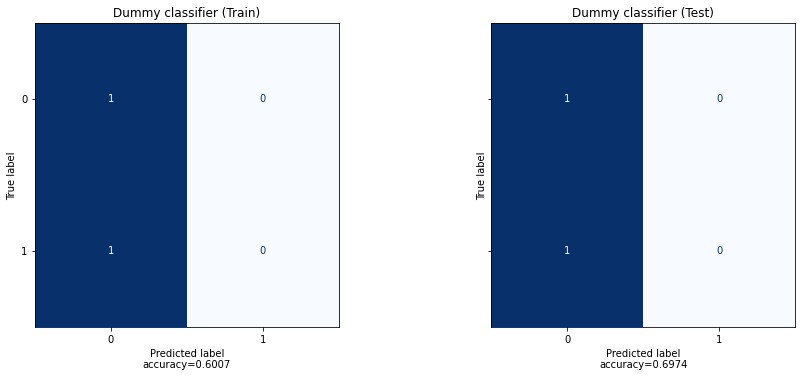

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent") # cria um objeto de classificador dummy com estratégia de mais frequente
dummy_clf.fit(X_train, y_train) # treina este classificador
cf_plot(dummy_clf, X_train, X_test, y_train, y_test, 'Dummy classifier')

Estas são as matrizes de confusão da partição de treino (a esquerda) e de teste (a direita), assim como a acurácia com cada partição na parte inferior. Deste resultado, esperamos que qualquer modelo com acurácia acima de 0,6007 no treino e 0,6974 no teste seja melhor do que uma escolha aleatória na nossa base.

## 6. Machine learning

Esta etapa compreende a modelagem estatística do problema, visando criar um modelo para predizer se um cavalo irá viver ou morrer dado suas condições de saúde. 

A metodologia de treinamento segue os seguintes passos:

1. Treinamento de 11 tipos diversos de modelos de machine learning utilizando os hiperparâmetros padrões na base pré-processada (Cenário 1)
1. Treinamento de 11 tipos diversos de modelos de machine learning utilizando os hiperparâmetros padrões na base pré-processada com remoção de alguns atributos (Cenário 2)
1. Treinamento de 11 tipos diversos de modelos de machine learning utilizando os hiperparâmetros padrões na base pré-processada com redução de dimensionalidade por PCA (Cenário 3)
1. Treinamento de 11 tipos diversos de modelos de machine learning utilizando os hiperparâmetros padrões na base pré-processada com balanceamento via SMOTE (Cenário 4)
1. Escolha dos 3 melhores modelos no melhor cenário anterior
1. Otimização dos 3 melhores modelos utilizando grid search e validação cruzada
1. Escolha do campeão

Os modelos serão avaliados com base em suas métricas de treino e teste, mais precisamente: (i) acurácia, (ii) recall, (iii) precision e (iv) f1-score, e também pela estabilidade dos resultados utilizando estas duas bases.

Os 11 modelos a serem avaliados são:
1. Logistic Regression
1. Extra Trees
1. Gradient Boosting
1. Suport Vector Machines
1. K-Nearest Neighbours
1. SGD
1. Decision Tree
1. Random Forest
1. XGBoost
1. MLP Neural Network

In [ ]:
# cria um dicionário com os modelos a serem treinados
modelos = [{'nome': 'logreg',
            'modelo': LogisticRegression},
           {'nome': 'etree',
            'modelo': ExtraTreesClassifier},
           {'nome': 'gradboost',
             'modelo': GradientBoostingClassifier}, 
           {'nome': 'adaboost',
             'modelo': AdaBoostClassifier},
             {'nome': 'SVC',
              'modelo': SVC},
            {'nome': 'KNN',
             'modelo': KNeighborsClassifier},
            {'nome': 'SGD',
             'modelo': SGDClassifier},
            {'nome': 'Dtree',
             'modelo': DecisionTreeClassifier},
            {'nome': 'RForest',
             'modelo': RandomForestClassifier},
            {'nome': 'XGBoost',
             'modelo': XGBClassifier},
            {'nome': 'MLP Network',
             'modelo': MLPClassifier}
          ]

### 6.1 Caso 1: Base original

Neste cenário 1, iremos utilizar a base tratada anteriormente para o treinamento.

In [ ]:
# Treina e avalia os modelos listados de forma iterativa
resultados = []
for model in modelos:
    time1 = datetime.datetime.now()
    x = ModeloAuxiliar(clf=model['modelo'])
    # treinar o modelo
    x.fit(X_train, y_train)   
    # gerar predicao
    x_pred_treino = x.predict(X_train)
    x_pred_teste = x.predict(X_test)
    # gerar score
    acuracidade_treino = round(x.score(X_train,y_train),10)
    acuracidade_teste = round(x.score(X_test,y_test),10)
    # score recall 
    score_recall_treino = round(recall_score(x_pred_treino,y_train),10)
    score_recall_teste = round(recall_score(x_pred_teste,y_test),10)
    # score presicion
    score_precision_treino = round(precision_score(x_pred_treino,y_train),10)
    score_precision_teste = round(precision_score(x_pred_teste,y_test),10)
    # f1 score
    score_f1_treino = round(f1_score(x_pred_treino,y_train),10)
    score_f1_teste = round(f1_score(x_pred_teste,y_test),10)
    time2 = datetime.datetime.now()
    duration=time2-time1
    resultados.append({'nome': model['nome'], 
                       'Acurácia (treino)': acuracidade_treino,
                       'Recall (treino)': score_recall_treino,
                       'Precision (treino)': score_precision_treino,
                       'F1-score (treino)': score_f1_treino,
                       'Acurácia (teste)': acuracidade_teste,
                       'Recall (teste)': score_recall_teste,
                       'Precision (teste)': score_precision_teste,
                       'F1-score (teste)': score_f1_teste,
                       'Estabilidade (acurácia)': acuracidade_treino - acuracidade_teste,
                       'Tempo (s)': duration.total_seconds()})

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
# resultados
pd.DataFrame(resultados).sort_values(by='F1-score (teste)', ascending=False)

,nome,Acurácia (treino),Recall (treino),Precision (treino),F1-score (treino),Acurácia (teste),Recall (teste),Precision (teste),F1-score (teste),Estabilidade (acurácia),Tempo (s)
1,etree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.216040
8,RForest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.237196
10,MLP Network,0.968198,0.964286,0.955752,0.960000,0.986842,1.000000,0.956522,0.977778,-0.018644,0.529851
9,XGBoost,0.968198,0.972727,0.946903,0.959641,0.934211,0.875000,0.913043,0.893617,0.033987,0.085417
4,SVC,0.879859,0.883495,0.805310,0.842593,0.921053,0.869565,0.869565,0.869565,-0.041194,0.031550
2,gradboost,0.978799,0.981982,0.964602,0.973214,0.894737,0.826087,0.826087,0.826087,0.084062,0.123441
0,logreg,0.812721,0.777778,0.743363,0.760181,0.815789,0.714286,0.652174,0.681818,-0.003069,0.026139
5,KNN,0.812721,0.840909,0.654867,0.736318,0.815789,0.736842,0.608696,0.666667,-0.003069,0.064312
7,Dtree,1.000000,1.000000,1.000000,1.000000,0.776316,0.615385,0.695652,0.653061,0.223684,0.016863
3,adaboost,0.844523,0.810811,0.796460,0.803571,0.802632,0.700000,0.608696,0.651163,0.041891,0.138633


É possível verificar que, com as métricas exibidas anteriormente, a maioria dos modelos apresentou boa performance, em especial os modelos Extra Tree, Random Forest e MLP Neural Network.

### 6.2 Caso 2: Base original com remoção de atributos

Neste cenário 2, iremos remover os atributos que apresentaram correlação menor que 0,10 em relação a variável predita conforme correlação de Kendall da base original.

In [ ]:
# remove as colunas correspondentes aos atributos com < 0,10 em relação a variável predita
train_columns = list(df_train.columns) # cria uma lista com o nome dos atributos
train_columns.remove('outcome') # remove a variável predita da lista criada
train_columns.remove('abdomo_protein') # remove a variável preditora abdomo_protein da lista criada
train_columns.remove('rectal_temp') # remove a variável preditora rectal_temp da lista criada
train_columns.remove('adult') # remove a variável preditora adult da lista criada
train_columns.remove('total_protein') # remove a variável preditora total_protein da lista criada
train_columns.remove('nasogastric_tube') # remove a variável preditora nasogastric_tube da lista criada

In [ ]:
# separação dos dados de treino e teste
X_train_removed = df_train[train_columns] # dataset com atributos preditivos de treino
y_train_removed = df_train['outcome'] # vetor com a variável predita de treino 
X_test_removed = df_test[train_columns] # dataset com atributos preditivos de teste
y_test_removed = df_test['outcome'] # vetor com a variável predita de teste

print("Número de registros no dataset X_train: ", X_train_removed.shape)
print("Número de registros no dataset y_train: ", y_train_removed.shape)
print("Número de registros no dataset X_test: ", X_test_removed.shape)
print("Número de registros no dataset y_test: ", y_test_removed.shape)

Número de registros no dataset X_train:  (283, 45)
Número de registros no dataset y_train:  (283,)
Número de registros no dataset X_test:  (76, 45)
Número de registros no dataset y_test:  (76,)


In [ ]:
# normaliza os dados (variáveis preditivas)
mm_scaler = preprocessing.MinMaxScaler() # cria um objeto normalizador
X_train_removed = mm_scaler.fit_transform(X_train_removed) # aplica o normalizador nas variáveis de treino
X_test_removed = mm_scaler.fit_transform(X_test_removed) # aplica o normalizador nas variáveis de teste

In [ ]:
# Treina e avalia os modelos listados de forma iterativa
resultados = []
for model in modelos:
    time1 = datetime.datetime.now()
    x = ModeloAuxiliar(clf=model['modelo'])
    # treinar o modelo
    x.fit(X_train_removed, y_train_removed)   
    # gerar predicao
    x_pred_treino = x.predict(X_train_removed)
    x_pred_teste = x.predict(X_test_removed)
    # gerar score
    acuracidade_treino = round(x.score(X_train_removed,y_train_removed),10)
    acuracidade_teste = round(x.score(X_test_removed,y_test_removed),10)
    # score recall 
    score_recall_treino = round(recall_score(x_pred_treino,y_train_removed),10)
    score_recall_teste = round(recall_score(x_pred_teste,y_test_removed),10)
    # score presicion
    score_precision_treino = round(precision_score(x_pred_treino,y_train_removed),10)
    score_precision_teste = round(precision_score(x_pred_teste,y_test_removed),10)
    # f1 score
    score_f1_treino = round(f1_score(x_pred_treino,y_train_removed),10)
    score_f1_teste = round(f1_score(x_pred_teste,y_test_removed),10)
    time2 = datetime.datetime.now()
    duration=time2-time1
    resultados.append({'nome': model['nome'], 
                       'Acurácia (treino)': acuracidade_treino,
                       'Recall (treino)': score_recall_treino,
                       'Precision (treino)': score_precision_treino,
                       'F1-score (treino)': score_f1_treino,
                       'Acurácia (teste)': acuracidade_teste,
                       'Recall (teste)': score_recall_teste,
                       'Precision (teste)': score_precision_teste,
                       'F1-score (teste)': score_f1_teste,
                       'Estabilidade (acurácia)': acuracidade_treino - acuracidade_teste,
                       'Tempo (s)': duration.total_seconds()})

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
# resultados
pd.DataFrame(resultados).sort_values(by='F1-score (teste)', ascending=False)

,nome,Acurácia (treino),Recall (treino),Precision (treino),F1-score (treino),Acurácia (teste),Recall (teste),Precision (teste),F1-score (teste),Estabilidade (acurácia),Tempo (s)
1,etree,0.996466,1.000000,0.991150,0.995556,0.986842,0.958333,1.000000,0.978723,0.009624,0.224300
8,RForest,0.996466,1.000000,0.991150,0.995556,0.986842,0.958333,1.000000,0.978723,0.009624,0.250528
10,MLP Network,0.957597,0.946903,0.946903,0.946903,0.947368,0.913043,0.913043,0.913043,0.010229,0.530680
2,gradboost,0.968198,0.964286,0.955752,0.960000,0.907895,0.833333,0.869565,0.851064,0.060303,0.107923
9,XGBoost,0.929329,0.926606,0.893805,0.909910,0.907895,0.833333,0.869565,0.851064,0.021434,0.056428
4,SVC,0.879859,0.883495,0.805310,0.842593,0.894737,0.826087,0.826087,0.826087,-0.014878,0.027923
7,Dtree,0.996466,1.000000,0.991150,0.995556,0.828947,0.750000,0.652174,0.697674,0.167519,0.012029
0,logreg,0.798587,0.759259,0.725664,0.742081,0.815789,0.714286,0.652174,0.681818,-0.017203,0.030664
6,SGD,0.802120,0.731707,0.796460,0.762712,0.802632,0.666667,0.695652,0.680851,-0.000511,0.014040
3,adaboost,0.819788,0.767241,0.787611,0.777293,0.815789,0.736842,0.608696,0.666667,0.003999,0.111284


De forma geral, apesar da baixa correlação apontada pelo método de Kendall, nota-se uma perda de performance ao remover alguns atributos do modelo. 

### 6.3 Caso 3: Base original com PCA

Neste cenário 3, iremos reduzir a quantidade de atibutos utilizando PCA. Para isto, foi definido que utilizaremos o número de dimensões correspondente à 95% da variabilidade original. 

In [ ]:
# redução de dimensionalidade por PCA
pca = PCA(n_components=0.95, random_state=seed) # cria um objeto do tipo PCA com o dimensões que representem 95% da variabilidade original
pca.fit(X_train)  # cria as novas dimensões
print('Número de novas dimensões:', pca.n_components_) # verifica número de dimensões criadas

Número de novas dimensões: 35


In [ ]:
# transformação das variáveis preditivas para adequação às novas dimensões
X_train_pca = pca.transform(X_train)  # transforma os dados de treino segundo o PCA criado
X_test_pca = pca.transform(X_test)  # transforma os dados de teste segundo o PCA criado

In [ ]:
# Treina e avalia os modelos listados de forma iterativa
resultados = []
for model in modelos:
    time1 = datetime.datetime.now()
    x = ModeloAuxiliar(clf=model['modelo'])
    # treinar o modelo
    x.fit(X_train_pca, y_train)   
    # gerar predicao
    x_pred_treino = x.predict(X_train_pca)
    x_pred_teste = x.predict(X_test_pca)
    # gerar score
    acuracidade_treino = round(x.score(X_train_pca,y_train),10)
    acuracidade_teste = round(x.score(X_test_pca,y_test),10)
    # score recall 
    score_recall_treino = round(recall_score(x_pred_treino,y_train),10)
    score_recall_teste = round(recall_score(x_pred_teste,y_test),10)
    # score presicion
    score_precision_treino = round(precision_score(x_pred_treino,y_train),10)
    score_precision_teste = round(precision_score(x_pred_teste,y_test),10)
    # f1 score
    score_f1_treino = round(f1_score(x_pred_treino,y_train),10)
    score_f1_teste = round(f1_score(x_pred_teste,y_test),10)
    time2 = datetime.datetime.now()
    duration=time2-time1
    resultados.append({'nome': model['nome'], 
                       'Acurácia (treino)': acuracidade_treino,
                       'Recall (treino)': score_recall_treino,
                       'Precision (treino)': score_precision_treino,
                       'F1-score (treino)': score_f1_treino,
                       'Acurácia (teste)': acuracidade_teste,
                       'Recall (teste)': score_recall_teste,
                       'Precision (teste)': score_precision_teste,
                       'F1-score (teste)': score_f1_teste,
                       'Estabilidade (acurácia)': acuracidade_treino - acuracidade_teste,
                       'Tempo (s)': duration.total_seconds()})

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
# resultados
pd.DataFrame(resultados).sort_values(by='F1-score (teste)', ascending=False)

,nome,Acurácia (treino),Recall (treino),Precision (treino),F1-score (treino),Acurácia (teste),Recall (teste),Precision (teste),F1-score (teste),Estabilidade (acurácia),Tempo (s)
1,etree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.216271
2,gradboost,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.325622
8,RForest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.262139
9,XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.100579
10,MLP Network,0.978799,0.973451,0.973451,0.973451,1.000000,1.000000,1.000000,1.000000,-0.021201,0.475069
7,Dtree,1.000000,1.000000,1.000000,1.000000,0.973684,0.956522,0.956522,0.956522,0.026316,0.016920
3,adaboost,0.968198,0.964286,0.955752,0.960000,0.960526,0.954545,0.913043,0.933333,0.007672,0.159299
4,SVC,0.897527,0.911765,0.823009,0.865116,0.934211,0.909091,0.869565,0.888889,-0.036684,0.023998
0,logreg,0.802120,0.766355,0.725664,0.745455,0.815789,0.680000,0.739130,0.708333,-0.013669,0.034336
5,KNN,0.809187,0.797980,0.699115,0.745283,0.802632,0.700000,0.608696,0.651163,0.006556,0.048097


De forma geral, os modelos estatísticos se beneficiaram dessa redução de dimensionalidade por PCA utilizando 35 dimensões (correspondendo a 95% da variabilidade original). Apesar deste ganho expressivo para alguns modelos, a aplicação do PCA adiciona mais uma camada entre os dados originais e o modelo preditivo, o que diminui sua explicabilidade.

### 6.4 Caso 4: Base original com balanceamento por SMOTE

Neste cenário 4 iremos aplicar balanceamento pro SMOTE na base original. Este balanceamento baseia-se na sobreamostragem para re-equilibrar o conjunto de treinamento original. Ao invés vez de realizar uma replicação simples das instâncias de classe minoritária, a ideia principal do SMOTE é apresentar exemplos sintéticos. 
Esses novos dados são criados por interpolação entre várias instâncias de classes minoritárias vizinhas, auxiliando assim os classificadores a melhorarem sua capacidade de generalização.

In [ ]:
oversampler= sv.distance_SMOTE() # cria um objeto de SMOTE
X_train_smote, y_train_smote = oversampler.sample(X_train, y_train) # aplica o SMOTE nos dados de treinamento 
print("Number transactions X_train dataset: ", X_train_smote.shape)
print("Number transactions y_train dataset: ", y_train_smote.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

2021-05-18 23:57:11,193:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Number transactions X_train dataset:  (340, 50)
Number transactions y_train dataset:  (340,)
Number transactions X_test dataset:  (76, 50)
Number transactions y_test dataset:  (76,)


In [ ]:
# Treina e avalia os modelos listados de forma iterativa
resultados = []
for model in modelos:
    time1 = datetime.datetime.now()
    x = ModeloAuxiliar(clf=model['modelo'])
    # treinar o modelo
    x.fit(X_train_smote, y_train_smote)   
    # gerar predicao
    x_pred_treino = x.predict(X_train_smote)
    x_pred_teste = x.predict(X_test)
    # gerar score
    acuracidade_treino = round(x.score(X_train_smote,y_train_smote),10)
    acuracidade_teste = round(x.score(X_test,y_test),10)
    # score recall 
    score_recall_treino = round(recall_score(x_pred_treino,y_train_smote),10)
    score_recall_teste = round(recall_score(x_pred_teste,y_test),10)
    # score presicion
    score_precision_treino = round(precision_score(x_pred_treino,y_train_smote),10)
    score_precision_teste = round(precision_score(x_pred_teste,y_test),10)
    # f1 score
    score_f1_treino = round(f1_score(x_pred_treino,y_train_smote),10)
    score_f1_teste = round(f1_score(x_pred_teste,y_test),10)
    time2 = datetime.datetime.now()
    duration=time2-time1
    resultados.append({'nome': model['nome'], 
                       'Acurácia (treino)': acuracidade_treino,
                       'Recall (treino)': score_recall_treino,
                       'Precision (treino)': score_precision_treino,
                       'F1-score (treino)': score_f1_treino,
                       'Acurácia (teste)': acuracidade_teste,
                       'Recall (teste)': score_recall_teste,
                       'Precision (teste)': score_precision_teste,
                       'F1-score (teste)': score_f1_teste,
                       'Estabilidade (acurácia)': acuracidade_treino - acuracidade_teste,
                       'Tempo (s)': duration.total_seconds()})

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
# resultados
pd.DataFrame(resultados).sort_values(by='F1-score (teste)', ascending=False)

,nome,Acurácia (treino),Recall (treino),Precision (treino),F1-score (treino),Acurácia (teste),Recall (teste),Precision (teste),F1-score (teste),Estabilidade (acurácia),Tempo (s)
1,etree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.217570
8,RForest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.277583
10,MLP Network,0.976471,0.960227,0.994118,0.976879,0.986842,1.000000,0.956522,0.977778,-0.010372,0.534237
2,gradboost,0.988235,0.988235,0.988235,0.988235,0.960526,0.916667,0.956522,0.936170,0.027709,0.158174
9,XGBoost,0.967647,0.964912,0.970588,0.967742,0.934211,0.846154,0.956522,0.897959,0.033437,0.073854
4,SVC,0.902941,0.866310,0.952941,0.907563,0.921053,0.840000,0.913043,0.875000,-0.018111,0.035054
7,Dtree,1.000000,1.000000,1.000000,1.000000,0.881579,0.791667,0.826087,0.808511,0.118421,0.012500
0,logreg,0.823529,0.812500,0.841176,0.826590,0.855263,0.714286,0.869565,0.784314,-0.031734,0.043561
3,adaboost,0.879412,0.895706,0.858824,0.876877,0.828947,0.678571,0.826087,0.745098,0.050464,0.127493
6,SGD,0.788235,0.726852,0.923529,0.813472,0.776316,0.583333,0.913043,0.711864,0.011920,0.013813


### 6.5 Escolha dos modelos para otimização

De forma geral, o melhor desempenho utilizando as métricas analisadas foi obtido no cenário 3 com a redução de dimensionalidade utilizando PCA. Entretanto, o resultado do cenário 1, com a base original, não ficou muito atrás. Sendo assim, por mais que o PCA consiga aumentar um pouco a performance dos nossos modelos, em geral a performance sem aplicação também é satisfatória. Aplicar o PCA significaria abrir mão de explicabilidade, pelo menos de forma direta.

Sendo assim, vamos seguir com o cenário 1 utilizando os três melhores algoritmos nele, a saber:

1. Extra Trees
1. Random Forest
1. MLP Neural Network

### 6.6 Otimização dos modelos

Para a otimização dos hiperparâmetros dos três modelos selecionados, utilizaremos Grid Search com validação cruzada de 5 kfolds. Dos três, dois modelos são baseados em árvores de decisão (Extra Trees e Random Forest) e um é uma rede neural (MLP).
Desta forma, conseguiríamos ter melhor explicabilidade nos modelos de árvore de decisão e, por último, no MLP, que é uma caixa preta e carece de um modelo dummy ou outros pacotes para mitigar essa baixa explicabilidade.  

#### 6.6.1 Extra Trees

#### 6.6.1.1 Treinamento do modelo estatístico

In [ ]:
# hiperparâmetros a serem modificados no modelo
etc_parameters = {'criterion':('gini', 'entropy'),'max_features':('auto', 'sqrt', 'log2'), 'n_estimators':[50, 100, 250], 'max_depth': [50, 100, 250]}

In [ ]:
etc = ExtraTreesClassifier(n_jobs= -1, random_state = seed) # cria um objeto do classificador
etc_clf = GridSearchCV(etc, etc_parameters, cv=5, verbose=0) # cria um objeto do GridSearch com validação cruzada
etc_clf.fit(X_train, y_train) # treina o modelo estatístico

GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            oob_score=False, random_state=10,
                                            verbose=0, warm_start=False),
             iid='deprecated', 

#### 6.6.1.2 Matriz de confusão

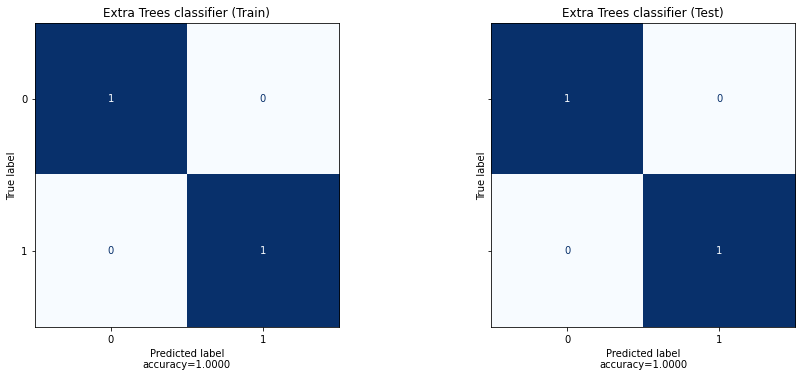

In [ ]:
# matrizes de confusão de treino e teste
cf_plot(etc_clf, X_train, X_test, y_train, y_test, 'Extra Trees classifier')

#### 6.6.1.3 Melhores hiperparâmetros encontrados

In [ ]:
# melhores hiperparâmetros encontrados na otimização
print('Melhores hiperparâmetros encontrados: \n')
etc_clf.best_params_

Melhores hiperparâmetros encontrados: 



{'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'log2',
 'n_estimators': 250}

#### 6.6.1.4 Validação cruzada

In [ ]:
etc = ExtraTreesClassifier(n_jobs= -1, random_state = seed, criterion = 'entropy', max_depth = 50, max_features = 'log2', n_estimators = 250) # cria um objeto do classificador com a melhor combinação de hyperparâmetros encontrados
etc.fit(X_train, y_train) # treina o modelo estatístico

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=50, max_features='log2',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
                     oob_score=False, random_state=10, verbose=0,
                     warm_start=False)

In [ ]:
kfold = KFold(n_splits=5) # define 5 kfolds
results = cross_val_score(etc, X_train, y_train, cv=kfold) # efetua a validação cruzada
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)) #exibe o resultado da validação cruzada

Accuracy: 72.76% (5.28%)


#### 6.6.2 Random Forest

#### 6.6.2.1 Treinamento do modelo estatístico

In [ ]:
# hiperparâmetros a serem modificados no modelo
rfc_parameters = {'criterion':('gini', 'entropy'),'max_features':('auto', 'sqrt', 'log2'), 'n_estimators':[50, 100, 250], 'max_depth': [50, 100, 250]}

In [ ]:
rfc = RandomForestClassifier(n_jobs= -1, random_state = seed) # cria um objeto do classificador
rfc_clf = GridSearchCV(rfc, rfc_parameters, cv=5, verbose=0) # cria um objeto do GridSearch com validação cruzada
rfc_clf.fit(X_train, y_train) # treina o modelo estatístico

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=10,
                                    

#### 6.6.2.2 Matriz de confusão

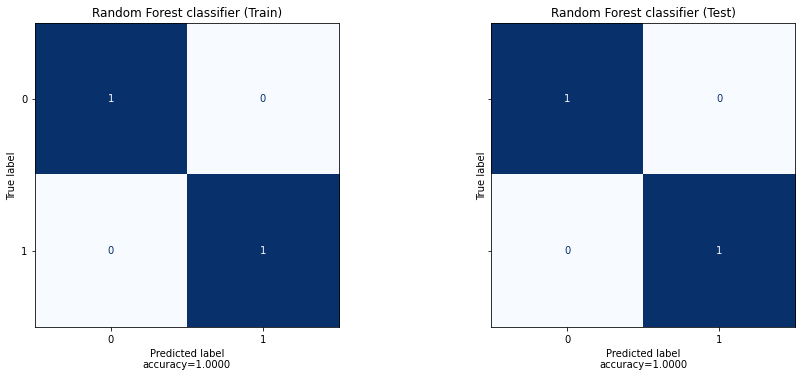

In [ ]:
# matrizes de confusão de treino e teste
cf_plot(rfc_clf, X_train, X_test, y_train, y_test, 'Random Forest classifier')

#### 6.6.2.3 Melhores hiperparâmetros encontrados

In [ ]:
# melhores hiperparâmetros encontrados na otimização
print('Melhores hiperparâmetros encontrados: \n')
rfc_clf.best_params_

Melhores hiperparâmetros encontrados: 



{'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'auto',
 'n_estimators': 250}

#### 6.6.2.4 Validação cruzada

In [ ]:
rfc = RandomForestClassifier(n_jobs= -1, random_state = seed, criterion = 'entropy', max_depth = 50, max_features = 'auto', n_estimators = 250) # cria um objeto do classificador com a melhor combinação de hyperparâmetros encontrados
rfc.fit(X_train, y_train) # treina o modelo estatístico

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [ ]:
kfold = KFold(n_splits=5) # define 5 kfolds
results = cross_val_score(rfc, X_train, y_train, cv=kfold) # efetua a validação cruzada
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)) #exibe o resultado da validação cruzada

Accuracy: 72.42% (2.61%)


#### 6.6.3 MLP Neural Network

No treinamento com os hiperparâmetros padrões, a rede neural MLP não convergiu com 200 épocas, sendo assim descartaremos esse valor e começaremos o treinamento com 500 épocas. 

#### 6.6.3.1 Treinamento do modelo estatístico

In [ ]:
# hiperparâmetros a serem modificados no modelo
mlp_parameters = {'hidden_layer_sizes':[50, 100, 200],'activation':('relu', 'logistic', 'tanh'), 'solver':('adam', 'sgd'), 'max_iter': [500, 1000]}

In [ ]:
mlp = MLPClassifier(random_state = seed) # cria um objeto do classificador
mlp_clf = GridSearchCV(mlp, mlp_parameters, cv=5, verbose=0) # cria um objeto do GridSearch com validação cruzada
mlp_clf.fit(X_train, y_train) # treina o modelo estatístico

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=10, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'

#### 6.6.3.2 Matriz de confusão

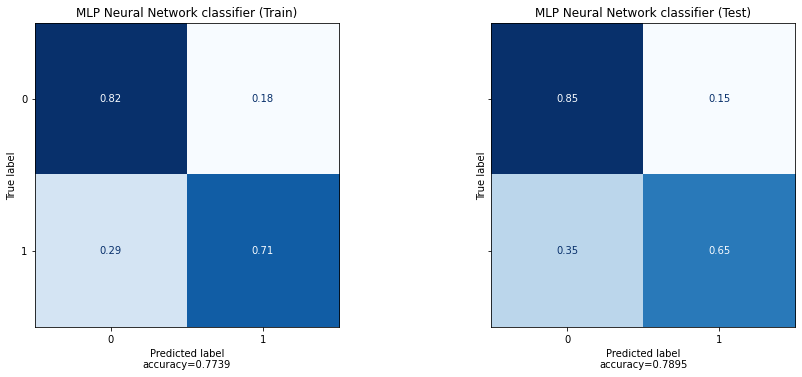

In [ ]:
# matrizes de confusão de treino e teste
cf_plot(mlp_clf, X_train, X_test, y_train, y_test, 'MLP Neural Network classifier')

#### 6.6.3.3 Melhores hiperparâmetros encontrados

In [ ]:
# melhores hiperparâmetros encontrados na otimização
mlp_clf.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': 200,
 'max_iter': 1000,
 'solver': 'sgd'}

#### 6.6.3.4 Validação cruzada

In [ ]:
mlp = MLPClassifier(random_state = seed, activation = 'relu', hidden_layer_sizes = 200, max_iter = 1000, solver = 'sgd') # cria um objeto do classificador com a melhor combinação de hyperparâmetros encontrados
mlp.fit(X_train, y_train) # treina o modelo estatístico

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=200, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=10, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
kfold = KFold(n_splits=5) # define 5 kfolds
results = cross_val_score(mlp, X_train, y_train, cv=kfold) # efetua a validação cruzada
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)) #exibe o resultado da validação cruzada

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy: 73.11% (4.15%)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#### 6.6.4 Resultados

Comparando as matrizes de confusão anteriores, os modelos Extra Trees e Random Forest atingiram acurácia de treinamento e teste de 100%, enquanto que a rede neural MLP ficou com performance em torno de 78%. É notório também que o otimizador do modelo de rede neural não conseguiu converger para os parâmetros fornecidos, sendo assim, iremos descartá-lo.

Por ter retornado as melhores métricas de avaliação em todos os cenários, incluindo na validação cruzada elege-se o modelo Extra trees como o campeão para esta aplicação.

#### 6.7 Modelo campeão

##### 6.7.1 Treinamento do modelo otimizado

In [ ]:
etc = ExtraTreesClassifier(n_jobs= -1, random_state = seed, criterion = 'entropy', max_depth = 50, max_features = 'log2', n_estimators = 250) # cria um objeto do classificador com a melhor combinação de hyperparâmetros encontrados
etc.fit(X_train, y_train) # treina o modelo estatístico

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=50, max_features='log2',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
                     oob_score=False, random_state=10, verbose=0,
                     warm_start=False)

##### 6.7.2 Explicabilidade do modelo

Nesta etapa, busca-se estudar as variáveis preditivas mais importantes para a predição do modelo. 

In [ ]:
importance = etc.feature_importances_ #salva a importância atribuídas pelo modelo às features num vetor

In [ ]:
atributos = list(df_train.columns) # cria uma lista com o nome dos atributos
atributos.remove('outcome') # remove a variável predita da lista criada

In [ ]:
# dataframe com a importância atribuída a cada variável preditora
d = {'Atributo':atributos,'Importância':list(importance)} # cria um dicionário de listas
df_explic = pd.DataFrame(d, columns=['Atributo','Importância']) # cria um datafreme de dicionário
df_explic.sort_values(by='Importância', ascending=False)

,Atributo,Importância
6,packed_cell_volume,0.051028
7,total_protein,0.048943
2,pulse,0.045167
10,surgical_lesion,0.041447
1,rectal_temp,0.038492
23,mucous_membrane_normal_pink,0.035981
18,peripheral_pulse_normal,0.035497
0,surgery,0.035062
3,respiratory_rate,0.033348
13,temp_of_extremities_cool,0.029739


As mesmas informações obtidas nesta tabela podem ser exibidas em um gráfico para melhor visualização.
Por delimitação de espaço, vamos realizar um corte de exibição para que somente as 15 variáveis preditoras com maior importância sejam exibidas.

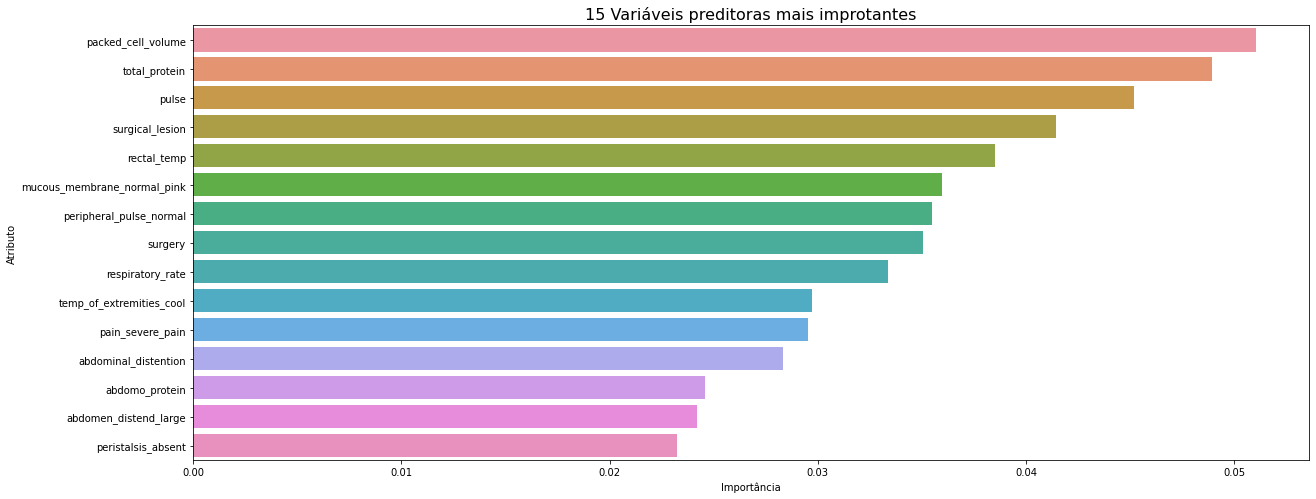

In [ ]:
#gráfico com as 15 variáveis preditoras mais importantes para o modelo estatístico escolhido
plt.figure(figsize=(20,8))
sns.barplot(x="Importância", y="Atributo", data=df_explic.sort_values(by='Importância', ascending=False)[:15])
plt.title('15 Variáveis preditoras mais improtantes', fontsize=16)
plt.xlabel('Importância')
plt.ylabel('Atributo')
plt.show()

Como pode ser visto, para a predição do modelo estatístico, a variável mais importante é a **packed_cell_volume**, seguida de **total_protein** e **pulse**.

Estas variáveis exibidas no gráfico anterior são as 15 mais importantes para que o modelo chege a conclusão se o cavalo irá sobreviver ou morrer.

É importante ressaltar que, apesar de ser possível ver a importância atribuida a cada variável pelo modelo, o modelo estatístico usa todas elas para a predição, o que significa que, ao remover alguma variável destas, a performance pode mudar, pois o mesmo identifica padrões ocultos entre as variáveis para fornecer maior robustez a decisão. 

## 7. Conclusões

Foi aplicado todo ciclo de ciência de dados na base fornecida sobre registro médico de cavalos. Começamos na exploração dos dados, onde foram realizadas análises uni e bivariadas, assim como gerados alguns insights. Na sequência, estudamos como tratar os dados ausentes e outliers, assim como efetuamos outros processamentos como balanceamento, normalização e encoding. 
Na etapa de modelagem estatísticas, foram testados onze modelos em 4 cenários bases (original, reduzido, PCA e balanceado por SMOTE). O melhor resultado encontrado foi no cenário utilizando PCA, mas optamos por seguir com o cenário original pela proximidade dos resultados e possibilidade de interpetação posterior do modelo.
Assim, após o processo de otimização de hiperparâmetros e validação cruzada, chegamos ao modelo campeão, Extra Trees, com uma performance de quase 77% de acurácia na validação cruzada e 100% de acurácia nas partições de treino e de teste.
Para finalizar, exploramos as variáveis preditoras mais importantes para a predição do modelo, onde chegamos num gráfico com as 15 mais importantes para isto.

Esta análise de explicabilidade é importante para analisarmos o peso atribuído a cada atributo, o que pode ajudar em discussões com a área de negócio quando necessário, além de tornar palpável nossos resultados para este público. Também é possível selecionar algumas variáveis e treinar o modelo novamente somente com as mais importantes, o que ajudaria a reduzir a complexibilidade do modelo (levando a tempos menores de aplicação e de geração de bases de propensão). 

Para este caso, não foi necessário seguir nenhuma dessas alternativas pois os modelos conseguiram se ajustar bem aos dados fornecidos. 